시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [ ]:
!git config --global user.email 'jinsolkn@gmail.com'
!git config --global user.name 'JinsolKN'

In [ ]:
cd /content/drive/MyDrive/colab/daegu_traffic/

/content/drive/MyDrive/colab/daegu_traffic


In [ ]:
!git add xgboost.ipynb
!git commit -m "directory update"
#!git commit -a "directory update"

[main 63340f1] directory update
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite xgboost.ipynb (84%)


In [ ]:
!git push -u origin main

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 782 bytes | 260.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/JinsolKN/daegu_traffic.git
   c31c1c3..63340f1  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [264]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [265]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [266]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [267]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [268]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서
child_cctv_df

,동,어린이CCTV설치대수
0,대명동,26
1,이천동,6
2,봉덕동,8
3,가창면,8
4,구지면,6
...,...,...
67,대신동,2
68,삼덕동2가,1
69,남일동,1
70,덕산동,1


In [269]:
#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64
(10963, 15)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64


In [270]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [271]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라
print(cctv_df['동'].unique())
print(train_df['동'].unique())

[ 4  1  2 99]
['대명동' '봉덕동' '이천동' '하빈면' '다사읍' '옥포읍' '구지면' '가창면' '현풍읍' '화원읍' '논공읍' '유가읍'
 '하리' '정대리' '용계리' '유가면' '현풍면' '남리' '세천리' '매곡리' '삼산리' '북리' '호림동' '용산동'
 '월암동' '호산동' '본리동' '월성동' '송현동' '이곡동' '장기동' '대천동' '신당동' '대곡동' '진천동' '상인동'
 '감삼동' '본동' '성당동' '유천동' '죽전동' '두류동' '도원동' '파호동' '남산동' '동산동' '공평동' '삼덕동2가'
 '봉산동' '동성로3가' '남일동' '문화동' '수동' '동인동3가' '대신동' '대봉동' '수창동' '대안동' '삼덕동3가'
 '동인동4가' '종로2가' '태평로1가' '삼덕동1가' '동성로2가' nan '종로1가' '북성로1가' '북성로2가' '서야동'
 '인교동' '계산동2가' '금호동' '미곡동' '팔달동' '범어동' '신천동' '지저동' '황금동' '봉무동' '내당동' '비산동'
 '수성동1가' '고모동' '만촌동' '도학동' '국우동' '태전동' '대현동' '파동' '범물동' '평광동' '도동' '덕곡동'
 '중동' '갈산동' '두산동' '율하동' '신평동' '평리동' '중리동' '침산동' '복현동' '산격동' '신매동' '조야동'
 '율암동' '서변동' '신서동' '입석동' '효목동' '평리4동' '매천동' '읍내동' '사복동' '신암동' '구암동' '지묘동'
 '노원동3가' '삼덕동' '신암4동' '백안동' '군위읍' '이현동' '신암1동' '비산2.3동' '지산동' '두류1.2동'
 '칠성동1가' '침산2동' '비산4동' '가천동' '상동' '시지동' '서성로2가' '태평로3가' '칠성동2가' '방촌동'
 '관음동' '부계면' '신기동' '수성동4가' '효령면' '노원동1가' '동인동2가' '노원동2가' '각산동' '신안동' '학정동'
 '괴전동' '동천동' '의흥면' '우보면' '미대동' '소보면' '상리동

In [272]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서
cctv_list

,동,CCTV개수
0,대명동,27
1,봉덕동,9
2,이천동,4
3,하빈면,12
4,다사읍,52
...,...,...
168,서성로1가,1
169,중대동,2
170,삼국유사면,1
171,부동,1


In [273]:
#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(train_df['CCTV개수'].mean())
print(train_df.isnull().sum())

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(train_df['CCTV개수'].mean())
print(test_df.isnull().sum())

(39609, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64
(10963, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [274]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [275]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [276]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

In [ ]:
train_df[(train_df['기상상태'] == '맑음')&(train_df['노면상태'] == '젖음/습기')]

,ID,요일,기상상태,노면상태,사고유형,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
356,ACCIDENT_00356,토요일,맑음,젖음/습기,차량단독,1,2019,1,12,6,대구광역시,수성구,범어동,교차로,교차로안
357,ACCIDENT_00357,토요일,맑음,젖음/습기,차대차,3,2019,1,12,6,대구광역시,서구,이현동,교차로,교차로부근
365,ACCIDENT_00365,토요일,맑음,젖음/습기,차대차,6,2019,1,12,12,대구광역시,수성구,황금동,단일로,기타
375,ACCIDENT_00375,토요일,맑음,젖음/습기,차대차,8,2019,1,12,17,대구광역시,서구,원대동3가,단일로,기타
433,ACCIDENT_00433,월요일,맑음,젖음/습기,차대차,3,2019,1,14,17,대구광역시,달성군,구지면,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38299,ACCIDENT_38299,월요일,맑음,젖음/습기,차대차,3,2021,11,22,1,대구광역시,북구,매천동,단일로,교량
38599,ACCIDENT_38599,화요일,맑음,젖음/습기,차대차,3,2021,11,30,16,대구광역시,북구,침산동,단일로,기타
38605,ACCIDENT_38605,화요일,맑음,젖음/습기,차대차,3,2021,11,30,17,대구광역시,달서구,월성동,교차로,교차로안
38612,ACCIDENT_38612,화요일,맑음,젖음/습기,차대차,6,2021,11,30,20,대구광역시,북구,관음동,교차로,교차로안


In [ ]:
road_pattern = r'(.+) - (.+)'

eda_train[['도로형태1', '도로형태2']] = eda_train['도로형태'].str.extract(road_pattern)
eda_train = eda_train.drop(columns=['도로형태'])


In [ ]:
eda_train

,ID,사고일시,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,사망자수,중상자수,경상자수,부상자수,ECLO,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,...,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,...,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,...,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,...,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,...,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,...,0,0,1,0,3,대구광역시,수성구,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,...,0,0,1,0,3,대구광역시,달서구,상인동,단일로,기타
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,...,0,2,0,0,10,대구광역시,달서구,월성동,교차로,교차로안
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,...,0,0,1,0,3,대구광역시,달서구,장동,기타,기타


In [ ]:
eda_train = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')

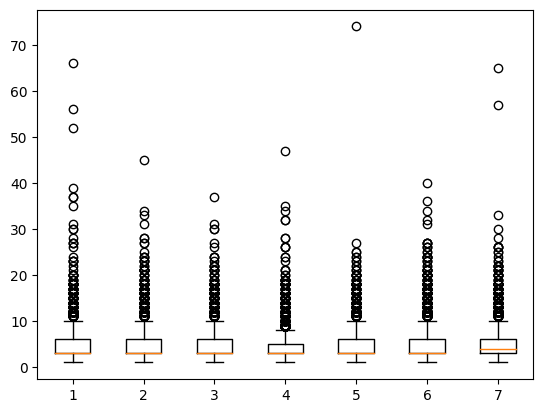

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

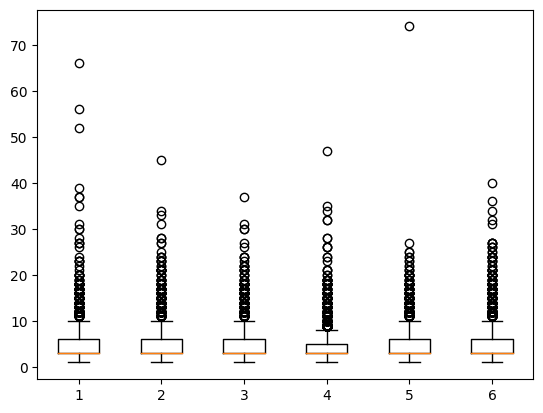

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

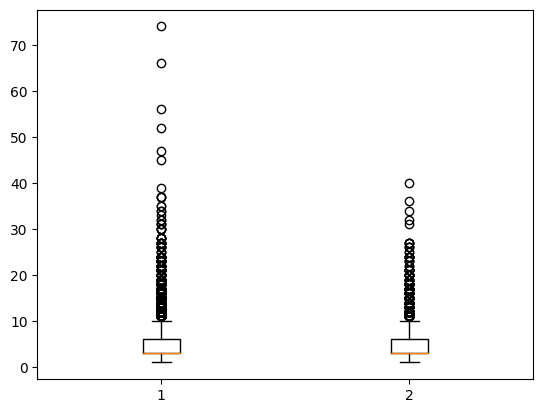

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

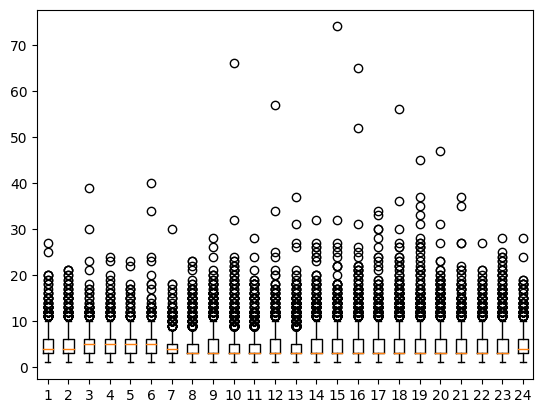

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

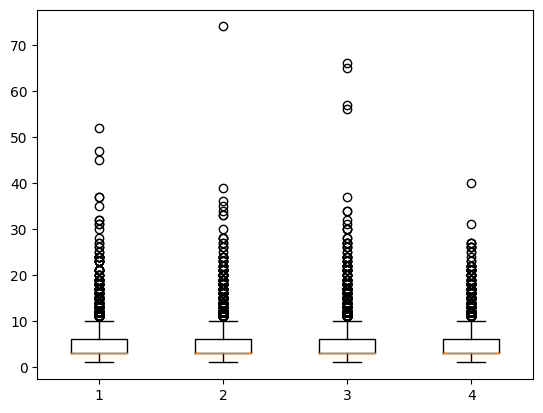

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [277]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 15) (39609,) (10963, 15)


In [278]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,2.0,1.0
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,0.0,4.0
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,5.0,4.0
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,11.0,10.0
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,0,6,118,0,3,1.0,1.0
39605,0,2,0,1,2021,12,31,19,0,1,103,2,5,0.0,18.0
39606,0,2,0,1,2021,12,31,21,0,1,144,0,3,0.0,9.0
39607,0,2,0,1,2021,12,31,22,0,1,158,1,5,0.0,1.0


In [279]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,5.0,4.000000
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,10.0,7.000000
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,1.0,1.000000
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,7.0,11.000000
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,0.0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,0,38,2,9,26.0,27.000000
10959,5,2,0,1,2022,12,31,18,0,6,123,2,5,5.0,4.000000
10960,5,2,0,1,2022,12,31,20,0,6,134,2,5,0.0,10.191645
10961,5,2,0,1,2022,12,31,20,0,6,77,0,2,7.0,7.000000


모델 훈련 및 예측

In [280]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-18 10:30:45,724] A new study created in memory with name: no-name-ede98499-d783-4269-9822-38d168e3e6a3


[0]	validation_0-rmsle:0.56514
[1]	validation_0-rmsle:0.54941
[2]	validation_0-rmsle:0.53404
[3]	validation_0-rmsle:0.51900
[4]	validation_0-rmsle:0.50431
[5]	validation_0-rmsle:0.49005
[6]	validation_0-rmsle:0.47610
[7]	validation_0-rmsle:0.46255
[8]	validation_0-rmsle:0.44935
[9]	validation_0-rmsle:0.43652
[10]	validation_0-rmsle:0.42411
[11]	validation_0-rmsle:0.41206
[12]	validation_0-rmsle:0.40039
[13]	validation_0-rmsle:0.38906
[14]	validation_0-rmsle:0.37809
[15]	validation_0-rmsle:0.36747
[16]	validation_0-rmsle:0.35726
[17]	validation_0-rmsle:0.34739
[18]	validation_0-rmsle:0.33793
[19]	validation_0-rmsle:0.32877
[20]	validation_0-rmsle:0.31997
[21]	validation_0-rmsle:0.31150
[22]	validation_0-rmsle:0.30339
[23]	validation_0-rmsle:0.29559
[24]	validation_0-rmsle:0.28816
[25]	validation_0-rmsle:0.28100
[26]	validation_0-rmsle:0.27422
[27]	validation_0-rmsle:0.26777
[28]	validation_0-rmsle:0.26156
[29]	validation_0-rmsle:0.25570
[30]	validation_0-rmsle:0.25015
[31]	validation_0-

[I 2023-11-18 10:30:50,336] Trial 0 finished with value: 0.4468535623472981 and parameters: {'lambda': 0.097600157019463, 'alpha': 0.8582224520500048, 'colsample_bytree': 0.7021757860267899, 'subsample': 0.4508564377688079, 'learning_rate': 0.04770228404692636, 'n_estimators': 555, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.56108
[1]	validation_0-rmsle:0.54150
[2]	validation_0-rmsle:0.52247
[3]	validation_0-rmsle:0.50401
[4]	validation_0-rmsle:0.48613
[5]	validation_0-rmsle:0.46886
[6]	validation_0-rmsle:0.45215
[7]	validation_0-rmsle:0.43603
[8]	validation_0-rmsle:0.42050
[9]	validation_0-rmsle:0.40550
[10]	validation_0-rmsle:0.39111
[11]	validation_0-rmsle:0.37730
[12]	validation_0-rmsle:0.36406
[13]	validation_0-rmsle:0.35141
[14]	validation_0-rmsle:0.33932
[15]	validation_0-rmsle:0.32779
[16]	validation_0-rmsle:0.31682
[17]	validation_0-rmsle:0.30640
[18]	validation_0-rmsle:0.29653
[19]	validation_0-rmsle:0.28716
[20]	validation_0-rmsle:0.27836
[21]	validation_0-rmsle:0.27006
[22]	validation_0-rmsle:0.26221
[23]	validation_0-rmsle:0.25484
[24]	validation_0-rmsle:0.24798
[25]	validation_0-rmsle:0.24149
[26]	validation_0-rmsle:0.23551
[27]	validation_0-rmsle:0.22997
[28]	validation_0-rmsle:0.22481
[29]	validation_0-rmsle:0.21999
[30]	validation_0-rmsle:0.21557
[31]	validation_0-

[I 2023-11-18 10:30:57,997] Trial 1 finished with value: 0.4470423901801172 and parameters: {'lambda': 0.0037832474552415146, 'alpha': 0.7800180081909369, 'colsample_bytree': 0.47058260067271884, 'subsample': 0.7852739070679355, 'learning_rate': 0.05984351730851677, 'n_estimators': 190, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.58108
[1]	validation_0-rmsle:0.58088
[2]	validation_0-rmsle:0.58069
[3]	validation_0-rmsle:0.58049
[4]	validation_0-rmsle:0.58030
[5]	validation_0-rmsle:0.58010
[6]	validation_0-rmsle:0.57991
[7]	validation_0-rmsle:0.57971
[8]	validation_0-rmsle:0.57952
[9]	validation_0-rmsle:0.57932
[10]	validation_0-rmsle:0.57912
[11]	validation_0-rmsle:0.57893
[12]	validation_0-rmsle:0.57874
[13]	validation_0-rmsle:0.57854
[14]	validation_0-rmsle:0.57835
[15]	validation_0-rmsle:0.57815
[16]	validation_0-rmsle:0.57796
[17]	validation_0-rmsle:0.57776
[18]	validation_0-rmsle:0.57757
[19]	validation_0-rmsle:0.57737
[20]	validation_0-rmsle:0.57718
[21]	validation_0-rmsle:0.57698
[22]	validation_0-rmsle:0.57679
[23]	validation_0-rmsle:0.57659
[24]	validation_0-rmsle:0.57640
[25]	validation_0-rmsle:0.57620
[26]	validation_0-rmsle:0.57601
[27]	validation_0-rmsle:0.57582
[28]	validation_0-rmsle:0.57562
[29]	validation_0-rmsle:0.57543
[30]	validation_0-rmsle:0.57523
[31]	validation_0-

[I 2023-11-18 10:31:04,940] Trial 2 finished with value: 1.0597168589058716 and parameters: {'lambda': 0.07692747435750542, 'alpha': 0.5215964196122191, 'colsample_bytree': 0.5096430684044583, 'subsample': 0.6670665433150841, 'learning_rate': 0.0005734063203215479, 'n_estimators': 613, 'max_depth': 6, 'min_child_weight': 23}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.56541
[1]	validation_0-rmsle:0.54992
[2]	validation_0-rmsle:0.53476
[3]	validation_0-rmsle:0.51994
[4]	validation_0-rmsle:0.50547
[5]	validation_0-rmsle:0.49141
[6]	validation_0-rmsle:0.47765
[7]	validation_0-rmsle:0.46428
[8]	validation_0-rmsle:0.45125
[9]	validation_0-rmsle:0.43857
[10]	validation_0-rmsle:0.42628
[11]	validation_0-rmsle:0.41434
[12]	validation_0-rmsle:0.40278
[13]	validation_0-rmsle:0.39153
[14]	validation_0-rmsle:0.38066
[15]	validation_0-rmsle:0.37012
[16]	validation_0-rmsle:0.35997
[17]	validation_0-rmsle:0.35014
[18]	validation_0-rmsle:0.34066
[19]	validation_0-rmsle:0.33155
[20]	validation_0-rmsle:0.32279
[21]	validation_0-rmsle:0.31434
[22]	validation_0-rmsle:0.30622
[23]	validation_0-rmsle:0.29842
[24]	validation_0-rmsle:0.29097
[25]	validation_0-rmsle:0.28380
[26]	validation_0-rmsle:0.27699
[27]	validation_0-rmsle:0.27052
[28]	validation_0-rmsle:0.26426
[29]	validation_0-rmsle:0.25835
[30]	validation_0-rmsle:0.25275
[31]	validation_0-

[I 2023-11-18 10:31:06,753] Trial 3 finished with value: 0.4483033084765923 and parameters: {'lambda': 0.005838439265583335, 'alpha': 0.9730528493707651, 'colsample_bytree': 0.8734220535023522, 'subsample': 0.5692417816056934, 'learning_rate': 0.046923944365648645, 'n_estimators': 120, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.56754
[1]	validation_0-rmsle:0.55410
[2]	validation_0-rmsle:0.54089
[3]	validation_0-rmsle:0.52795
[4]	validation_0-rmsle:0.51527
[5]	validation_0-rmsle:0.50288
[6]	validation_0-rmsle:0.49073
[7]	validation_0-rmsle:0.47888
[8]	validation_0-rmsle:0.46728
[9]	validation_0-rmsle:0.45593
[10]	validation_0-rmsle:0.44484
[11]	validation_0-rmsle:0.43406
[12]	validation_0-rmsle:0.42353
[13]	validation_0-rmsle:0.41328
[14]	validation_0-rmsle:0.40328
[15]	validation_0-rmsle:0.39354
[16]	validation_0-rmsle:0.38410
[17]	validation_0-rmsle:0.37491
[18]	validation_0-rmsle:0.36599
[19]	validation_0-rmsle:0.35731
[20]	validation_0-rmsle:0.34892
[21]	validation_0-rmsle:0.34078
[22]	validation_0-rmsle:0.33290
[23]	validation_0-rmsle:0.32524
[24]	validation_0-rmsle:0.31786
[25]	validation_0-rmsle:0.31069
[26]	validation_0-rmsle:0.30381
[27]	validation_0-rmsle:0.29721
[28]	validation_0-rmsle:0.29077
[29]	validation_0-rmsle:0.28459
[30]	validation_0-rmsle:0.27869
[31]	validation_0-

[I 2023-11-18 10:31:17,801] Trial 4 finished with value: 0.44698357036169906 and parameters: {'lambda': 0.045897901173332915, 'alpha': 0.6879895191852143, 'colsample_bytree': 0.4584062419948315, 'subsample': 0.6437486313517771, 'learning_rate': 0.0405690681857949, 'n_estimators': 814, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.57826
[1]	validation_0-rmsle:0.57526
[2]	validation_0-rmsle:0.57227
[3]	validation_0-rmsle:0.56930
[4]	validation_0-rmsle:0.56633
[5]	validation_0-rmsle:0.56339
[6]	validation_0-rmsle:0.56045
[7]	validation_0-rmsle:0.55753
[8]	validation_0-rmsle:0.55461
[9]	validation_0-rmsle:0.55171
[10]	validation_0-rmsle:0.54883
[11]	validation_0-rmsle:0.54595
[12]	validation_0-rmsle:0.54310
[13]	validation_0-rmsle:0.54025
[14]	validation_0-rmsle:0.53741
[15]	validation_0-rmsle:0.53459
[16]	validation_0-rmsle:0.53178
[17]	validation_0-rmsle:0.52898
[18]	validation_0-rmsle:0.52620
[19]	validation_0-rmsle:0.52343
[20]	validation_0-rmsle:0.52068
[21]	validation_0-rmsle:0.51793
[22]	validation_0-rmsle:0.51519
[23]	validation_0-rmsle:0.51247
[24]	validation_0-rmsle:0.50976
[25]	validation_0-rmsle:0.50705
[26]	validation_0-rmsle:0.50437
[27]	validation_0-rmsle:0.50170
[28]	validation_0-rmsle:0.49903
[29]	validation_0-rmsle:0.49639
[30]	validation_0-rmsle:0.49375
[31]	validation_0-

[I 2023-11-18 10:31:36,850] Trial 5 finished with value: 0.4482353635466502 and parameters: {'lambda': 0.0924238603730928, 'alpha': 0.12931187609810507, 'colsample_bytree': 0.7616638287848592, 'subsample': 0.5678509652124514, 'learning_rate': 0.008841094616395581, 'n_estimators': 589, 'max_depth': 7, 'min_child_weight': 41}. Best is trial 0 with value: 0.4468535623472981.


[0]	validation_0-rmsle:0.56636
[1]	validation_0-rmsle:0.55177
[2]	validation_0-rmsle:0.53749
[3]	validation_0-rmsle:0.52350
[4]	validation_0-rmsle:0.50981
[5]	validation_0-rmsle:0.49650
[6]	validation_0-rmsle:0.48344
[7]	validation_0-rmsle:0.47072
[8]	validation_0-rmsle:0.45831
[9]	validation_0-rmsle:0.44620
[10]	validation_0-rmsle:0.43445
[11]	validation_0-rmsle:0.42302
[12]	validation_0-rmsle:0.41190
[13]	validation_0-rmsle:0.40106
[14]	validation_0-rmsle:0.39055
[15]	validation_0-rmsle:0.38033
[16]	validation_0-rmsle:0.37045
[17]	validation_0-rmsle:0.36088
[18]	validation_0-rmsle:0.35165
[19]	validation_0-rmsle:0.34268
[20]	validation_0-rmsle:0.33400
[21]	validation_0-rmsle:0.32563
[22]	validation_0-rmsle:0.31760
[23]	validation_0-rmsle:0.30984
[24]	validation_0-rmsle:0.30238
[25]	validation_0-rmsle:0.29518
[26]	validation_0-rmsle:0.28829
[27]	validation_0-rmsle:0.28170
[28]	validation_0-rmsle:0.27531
[29]	validation_0-rmsle:0.26924
[30]	validation_0-rmsle:0.26346
[31]	validation_0-

[I 2023-11-18 10:31:40,997] Trial 6 finished with value: 0.4466591716257552 and parameters: {'lambda': 0.055352970257524094, 'alpha': 0.2008931587472666, 'colsample_bytree': 0.9635242102599227, 'subsample': 0.41973053319523623, 'learning_rate': 0.044085345775445324, 'n_estimators': 795, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57906
[1]	validation_0-rmsle:0.57686
[2]	validation_0-rmsle:0.57466
[3]	validation_0-rmsle:0.57247
[4]	validation_0-rmsle:0.57028
[5]	validation_0-rmsle:0.56810
[6]	validation_0-rmsle:0.56593
[7]	validation_0-rmsle:0.56377
[8]	validation_0-rmsle:0.56161
[9]	validation_0-rmsle:0.55946
[10]	validation_0-rmsle:0.55731
[11]	validation_0-rmsle:0.55518
[12]	validation_0-rmsle:0.55305
[13]	validation_0-rmsle:0.55092
[14]	validation_0-rmsle:0.54880
[15]	validation_0-rmsle:0.54669
[16]	validation_0-rmsle:0.54459
[17]	validation_0-rmsle:0.54249
[18]	validation_0-rmsle:0.54040
[19]	validation_0-rmsle:0.53832
[20]	validation_0-rmsle:0.53624
[21]	validation_0-rmsle:0.53417
[22]	validation_0-rmsle:0.53211
[23]	validation_0-rmsle:0.53005
[24]	validation_0-rmsle:0.52800
[25]	validation_0-rmsle:0.52596
[26]	validation_0-rmsle:0.52392
[27]	validation_0-rmsle:0.52189
[28]	validation_0-rmsle:0.51987
[29]	validation_0-rmsle:0.51785
[30]	validation_0-rmsle:0.51584
[31]	validation_0-

[I 2023-11-18 10:31:43,567] Trial 7 finished with value: 0.7172446922487506 and parameters: {'lambda': 0.03272822630436662, 'alpha': 0.3223363006282802, 'colsample_bytree': 0.8816435028020532, 'subsample': 0.766196636302302, 'learning_rate': 0.0064899502690619285, 'n_estimators': 190, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.55644
[1]	validation_0-rmsle:0.53249
[2]	validation_0-rmsle:0.50939
[3]	validation_0-rmsle:0.48714
[4]	validation_0-rmsle:0.46579
[5]	validation_0-rmsle:0.44534
[6]	validation_0-rmsle:0.42577
[7]	validation_0-rmsle:0.40710
[8]	validation_0-rmsle:0.38931
[9]	validation_0-rmsle:0.37238
[10]	validation_0-rmsle:0.35631
[11]	validation_0-rmsle:0.34111
[12]	validation_0-rmsle:0.32676
[13]	validation_0-rmsle:0.31331
[14]	validation_0-rmsle:0.30067
[15]	validation_0-rmsle:0.28887
[16]	validation_0-rmsle:0.27788
[17]	validation_0-rmsle:0.26766
[18]	validation_0-rmsle:0.25822
[19]	validation_0-rmsle:0.24943
[20]	validation_0-rmsle:0.24140
[21]	validation_0-rmsle:0.23405
[22]	validation_0-rmsle:0.22727
[23]	validation_0-rmsle:0.22111
[24]	validation_0-rmsle:0.21552
[25]	validation_0-rmsle:0.21047
[26]	validation_0-rmsle:0.20595
[27]	validation_0-rmsle:0.20185
[28]	validation_0-rmsle:0.19821
[29]	validation_0-rmsle:0.19495
[30]	validation_0-rmsle:0.19208
[31]	validation_0-

[I 2023-11-18 10:31:52,106] Trial 8 finished with value: 0.446955391676933 and parameters: {'lambda': 0.06673587764407524, 'alpha': 0.21765121662726875, 'colsample_bytree': 0.6452250562844392, 'subsample': 0.9546169997046279, 'learning_rate': 0.07386423353191886, 'n_estimators': 255, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.55978
[1]	validation_0-rmsle:0.53895
[2]	validation_0-rmsle:0.51876
[3]	validation_0-rmsle:0.49921
[4]	validation_0-rmsle:0.48032
[5]	validation_0-rmsle:0.46210
[6]	validation_0-rmsle:0.44452
[7]	validation_0-rmsle:0.42761
[8]	validation_0-rmsle:0.41137
[9]	validation_0-rmsle:0.39575
[10]	validation_0-rmsle:0.38083
[11]	validation_0-rmsle:0.36656
[12]	validation_0-rmsle:0.35292
[13]	validation_0-rmsle:0.33993
[14]	validation_0-rmsle:0.32760
[15]	validation_0-rmsle:0.31589
[16]	validation_0-rmsle:0.30481
[17]	validation_0-rmsle:0.29434
[18]	validation_0-rmsle:0.28446
[19]	validation_0-rmsle:0.27517
[20]	validation_0-rmsle:0.26648
[21]	validation_0-rmsle:0.25834
[22]	validation_0-rmsle:0.25073
[23]	validation_0-rmsle:0.24363
[24]	validation_0-rmsle:0.23706
[25]	validation_0-rmsle:0.23092
[26]	validation_0-rmsle:0.22530
[27]	validation_0-rmsle:0.22011
[28]	validation_0-rmsle:0.21532
[29]	validation_0-rmsle:0.21094
[30]	validation_0-rmsle:0.20693
[31]	validation_0-

[I 2023-11-18 10:31:55,194] Trial 9 finished with value: 0.4471023194155651 and parameters: {'lambda': 0.07927875745466749, 'alpha': 0.2738107492621281, 'colsample_bytree': 0.9970529776515379, 'subsample': 0.8476321795646755, 'learning_rate': 0.06377457632499985, 'n_estimators': 573, 'max_depth': 8, 'min_child_weight': 39}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.54799
[1]	validation_0-rmsle:0.51628
[2]	validation_0-rmsle:0.48615
[3]	validation_0-rmsle:0.45756
[4]	validation_0-rmsle:0.43056
[5]	validation_0-rmsle:0.40531
[6]	validation_0-rmsle:0.38149
[7]	validation_0-rmsle:0.35930
[8]	validation_0-rmsle:0.33872
[9]	validation_0-rmsle:0.31966
[10]	validation_0-rmsle:0.30225
[11]	validation_0-rmsle:0.28633
[12]	validation_0-rmsle:0.27184
[13]	validation_0-rmsle:0.25868
[14]	validation_0-rmsle:0.24691
[15]	validation_0-rmsle:0.23636
[16]	validation_0-rmsle:0.22705
[17]	validation_0-rmsle:0.21885
[18]	validation_0-rmsle:0.21171
[19]	validation_0-rmsle:0.20542
[20]	validation_0-rmsle:0.19996
[21]	validation_0-rmsle:0.19530
[22]	validation_0-rmsle:0.19139
[23]	validation_0-rmsle:0.18804
[24]	validation_0-rmsle:0.18522
[25]	validation_0-rmsle:0.18279
[26]	validation_0-rmsle:0.18076
[27]	validation_0-rmsle:0.17912
[28]	validation_0-rmsle:0.17764
[29]	validation_0-rmsle:0.17648
[30]	validation_0-rmsle:0.17558
[31]	validation_0-

[I 2023-11-18 10:31:57,581] Trial 10 finished with value: 0.44799428296195765 and parameters: {'lambda': 0.053776364018641686, 'alpha': 0.03589620460588361, 'colsample_bytree': 0.9893725610382816, 'subsample': 0.41998318492128356, 'learning_rate': 0.09953333919096911, 'n_estimators': 887, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57057
[1]	validation_0-rmsle:0.56005
[2]	validation_0-rmsle:0.54968
[3]	validation_0-rmsle:0.53947
[4]	validation_0-rmsle:0.52939
[5]	validation_0-rmsle:0.51954
[6]	validation_0-rmsle:0.50981
[7]	validation_0-rmsle:0.50025
[8]	validation_0-rmsle:0.49085
[9]	validation_0-rmsle:0.48158
[10]	validation_0-rmsle:0.47251
[11]	validation_0-rmsle:0.46360
[12]	validation_0-rmsle:0.45484
[13]	validation_0-rmsle:0.44625
[14]	validation_0-rmsle:0.43781
[15]	validation_0-rmsle:0.42952
[16]	validation_0-rmsle:0.42142
[17]	validation_0-rmsle:0.41348
[18]	validation_0-rmsle:0.40572
[19]	validation_0-rmsle:0.39809
[20]	validation_0-rmsle:0.39061
[21]	validation_0-rmsle:0.38330
[22]	validation_0-rmsle:0.37616
[23]	validation_0-rmsle:0.36916
[24]	validation_0-rmsle:0.36233
[25]	validation_0-rmsle:0.35563
[26]	validation_0-rmsle:0.34912
[27]	validation_0-rmsle:0.34277
[28]	validation_0-rmsle:0.33654
[29]	validation_0-rmsle:0.33048
[30]	validation_0-rmsle:0.32460
[31]	validation_0-

[I 2023-11-18 10:32:09,754] Trial 11 finished with value: 0.4470592572084172 and parameters: {'lambda': 0.09445313817007825, 'alpha': 0.3985812627593237, 'colsample_bytree': 0.6577392184906234, 'subsample': 0.40979636678660536, 'learning_rate': 0.031536645408658366, 'n_estimators': 765, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57159
[1]	validation_0-rmsle:0.56206
[2]	validation_0-rmsle:0.55265
[3]	validation_0-rmsle:0.54336
[4]	validation_0-rmsle:0.53419
[5]	validation_0-rmsle:0.52519
[6]	validation_0-rmsle:0.51629
[7]	validation_0-rmsle:0.50753
[8]	validation_0-rmsle:0.49890
[9]	validation_0-rmsle:0.49039
[10]	validation_0-rmsle:0.48205
[11]	validation_0-rmsle:0.47383
[12]	validation_0-rmsle:0.46576
[13]	validation_0-rmsle:0.45779
[14]	validation_0-rmsle:0.44996
[15]	validation_0-rmsle:0.44225
[16]	validation_0-rmsle:0.43470
[17]	validation_0-rmsle:0.42726
[18]	validation_0-rmsle:0.41999
[19]	validation_0-rmsle:0.41283
[20]	validation_0-rmsle:0.40580
[21]	validation_0-rmsle:0.39888
[22]	validation_0-rmsle:0.39212
[23]	validation_0-rmsle:0.38545
[24]	validation_0-rmsle:0.37894
[25]	validation_0-rmsle:0.37254
[26]	validation_0-rmsle:0.36628
[27]	validation_0-rmsle:0.36018
[28]	validation_0-rmsle:0.35416
[29]	validation_0-rmsle:0.34829
[30]	validation_0-rmsle:0.34256
[31]	validation_0-

[I 2023-11-18 10:32:15,805] Trial 12 finished with value: 0.4467417250955717 and parameters: {'lambda': 0.0960754452318893, 'alpha': 0.5112502305045847, 'colsample_bytree': 0.7295669333158169, 'subsample': 0.46981876647368337, 'learning_rate': 0.028509308426201526, 'n_estimators': 398, 'max_depth': 5, 'min_child_weight': 30}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57055
[1]	validation_0-rmsle:0.56001
[2]	validation_0-rmsle:0.54962
[3]	validation_0-rmsle:0.53938
[4]	validation_0-rmsle:0.52930
[5]	validation_0-rmsle:0.51941
[6]	validation_0-rmsle:0.50964
[7]	validation_0-rmsle:0.50006
[8]	validation_0-rmsle:0.49062
[9]	validation_0-rmsle:0.48134
[10]	validation_0-rmsle:0.47226
[11]	validation_0-rmsle:0.46334
[12]	validation_0-rmsle:0.45458
[13]	validation_0-rmsle:0.44597
[14]	validation_0-rmsle:0.43751
[15]	validation_0-rmsle:0.42921
[16]	validation_0-rmsle:0.42109
[17]	validation_0-rmsle:0.41313
[18]	validation_0-rmsle:0.40536
[19]	validation_0-rmsle:0.39772
[20]	validation_0-rmsle:0.39024
[21]	validation_0-rmsle:0.38292
[22]	validation_0-rmsle:0.37576
[23]	validation_0-rmsle:0.36873
[24]	validation_0-rmsle:0.36191
[25]	validation_0-rmsle:0.35520
[26]	validation_0-rmsle:0.34868
[27]	validation_0-rmsle:0.34234
[28]	validation_0-rmsle:0.33611
[29]	validation_0-rmsle:0.33006
[30]	validation_0-rmsle:0.32417
[31]	validation_0-

[I 2023-11-18 10:32:26,474] Trial 13 finished with value: 0.4467418570521025 and parameters: {'lambda': 0.06663995818737663, 'alpha': 0.5144218762316898, 'colsample_bytree': 0.8156927502850305, 'subsample': 0.49570092542504024, 'learning_rate': 0.03158656406527311, 'n_estimators': 361, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57487
[1]	validation_0-rmsle:0.56854
[2]	validation_0-rmsle:0.56225
[3]	validation_0-rmsle:0.55603
[4]	validation_0-rmsle:0.54985
[5]	validation_0-rmsle:0.54375
[6]	validation_0-rmsle:0.53769
[7]	validation_0-rmsle:0.53170
[8]	validation_0-rmsle:0.52575
[9]	validation_0-rmsle:0.51986
[10]	validation_0-rmsle:0.51404
[11]	validation_0-rmsle:0.50828
[12]	validation_0-rmsle:0.50257
[13]	validation_0-rmsle:0.49692
[14]	validation_0-rmsle:0.49132
[15]	validation_0-rmsle:0.48578
[16]	validation_0-rmsle:0.48030
[17]	validation_0-rmsle:0.47488
[18]	validation_0-rmsle:0.46953
[19]	validation_0-rmsle:0.46422
[20]	validation_0-rmsle:0.45898
[21]	validation_0-rmsle:0.45379
[22]	validation_0-rmsle:0.44865
[23]	validation_0-rmsle:0.44356
[24]	validation_0-rmsle:0.43855
[25]	validation_0-rmsle:0.43357
[26]	validation_0-rmsle:0.42866
[27]	validation_0-rmsle:0.42383
[28]	validation_0-rmsle:0.41903
[29]	validation_0-rmsle:0.41430
[30]	validation_0-rmsle:0.40963
[31]	validation_0-

[I 2023-11-18 10:32:42,684] Trial 14 finished with value: 0.4468286200755357 and parameters: {'lambda': 0.08398969078623927, 'alpha': 0.40779673687355544, 'colsample_bytree': 0.5439568071485263, 'subsample': 0.5215581694042668, 'learning_rate': 0.018818710933529496, 'n_estimators': 988, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57369
[1]	validation_0-rmsle:0.56619
[2]	validation_0-rmsle:0.55877
[3]	validation_0-rmsle:0.55143
[4]	validation_0-rmsle:0.54415
[5]	validation_0-rmsle:0.53700
[6]	validation_0-rmsle:0.52989
[7]	validation_0-rmsle:0.52288
[8]	validation_0-rmsle:0.51594
[9]	validation_0-rmsle:0.50907
[10]	validation_0-rmsle:0.50230
[11]	validation_0-rmsle:0.49561
[12]	validation_0-rmsle:0.48899
[13]	validation_0-rmsle:0.48246
[14]	validation_0-rmsle:0.47600
[15]	validation_0-rmsle:0.46963
[16]	validation_0-rmsle:0.46334
[17]	validation_0-rmsle:0.45714
[18]	validation_0-rmsle:0.45103
[19]	validation_0-rmsle:0.44498
[20]	validation_0-rmsle:0.43901
[21]	validation_0-rmsle:0.43312
[22]	validation_0-rmsle:0.42731
[23]	validation_0-rmsle:0.42158
[24]	validation_0-rmsle:0.41593
[25]	validation_0-rmsle:0.41035
[26]	validation_0-rmsle:0.40488
[27]	validation_0-rmsle:0.39948
[28]	validation_0-rmsle:0.39413
[29]	validation_0-rmsle:0.38889
[30]	validation_0-rmsle:0.38373
[31]	validation_0-

[I 2023-11-18 10:32:49,372] Trial 15 finished with value: 0.4469520331658707 and parameters: {'lambda': 0.06859501434517336, 'alpha': 0.1607564242683852, 'colsample_bytree': 0.5884365872527801, 'subsample': 0.40310498286642316, 'learning_rate': 0.02232517203063602, 'n_estimators': 404, 'max_depth': 7, 'min_child_weight': 33}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57016
[1]	validation_0-rmsle:0.55923
[2]	validation_0-rmsle:0.54846
[3]	validation_0-rmsle:0.53786
[4]	validation_0-rmsle:0.52743
[5]	validation_0-rmsle:0.51721
[6]	validation_0-rmsle:0.50712
[7]	validation_0-rmsle:0.49722
[8]	validation_0-rmsle:0.48748
[9]	validation_0-rmsle:0.47792
[10]	validation_0-rmsle:0.46856
[11]	validation_0-rmsle:0.45938
[12]	validation_0-rmsle:0.45037
[13]	validation_0-rmsle:0.44152
[14]	validation_0-rmsle:0.43284
[15]	validation_0-rmsle:0.42433
[16]	validation_0-rmsle:0.41601
[17]	validation_0-rmsle:0.40787
[18]	validation_0-rmsle:0.39992
[19]	validation_0-rmsle:0.39212
[20]	validation_0-rmsle:0.38451
[21]	validation_0-rmsle:0.37706
[22]	validation_0-rmsle:0.36977
[23]	validation_0-rmsle:0.36262
[24]	validation_0-rmsle:0.35569
[25]	validation_0-rmsle:0.34889
[26]	validation_0-rmsle:0.34229
[27]	validation_0-rmsle:0.33588
[28]	validation_0-rmsle:0.32958
[29]	validation_0-rmsle:0.32348
[30]	validation_0-rmsle:0.31755
[31]	validation_0-

[I 2023-11-18 10:33:01,679] Trial 16 finished with value: 0.446789568104406 and parameters: {'lambda': 0.08579910929838819, 'alpha': 0.6059232793418824, 'colsample_bytree': 0.7652824559260186, 'subsample': 0.4956972998577823, 'learning_rate': 0.03276790692591862, 'n_estimators': 712, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57466
[1]	validation_0-rmsle:0.56811
[2]	validation_0-rmsle:0.56162
[3]	validation_0-rmsle:0.55518
[4]	validation_0-rmsle:0.54880
[5]	validation_0-rmsle:0.54250
[6]	validation_0-rmsle:0.53624
[7]	validation_0-rmsle:0.53006
[8]	validation_0-rmsle:0.52393
[9]	validation_0-rmsle:0.51786
[10]	validation_0-rmsle:0.51186
[11]	validation_0-rmsle:0.50592
[12]	validation_0-rmsle:0.50005
[13]	validation_0-rmsle:0.49423
[14]	validation_0-rmsle:0.48847
[15]	validation_0-rmsle:0.48277
[16]	validation_0-rmsle:0.47714
[17]	validation_0-rmsle:0.47157
[18]	validation_0-rmsle:0.46606
[19]	validation_0-rmsle:0.46062
[20]	validation_0-rmsle:0.45524
[21]	validation_0-rmsle:0.44991
[22]	validation_0-rmsle:0.44464
[23]	validation_0-rmsle:0.43943
[24]	validation_0-rmsle:0.43429
[25]	validation_0-rmsle:0.42920
[26]	validation_0-rmsle:0.42418
[27]	validation_0-rmsle:0.41924
[28]	validation_0-rmsle:0.41432
[29]	validation_0-rmsle:0.40948
[30]	validation_0-rmsle:0.40470
[31]	validation_0-

[I 2023-11-18 10:33:08,775] Trial 17 finished with value: 0.44680439039341047 and parameters: {'lambda': 0.052675040240651054, 'alpha': 0.39566456147944257, 'colsample_bytree': 0.9150998632229619, 'subsample': 0.5992981808798217, 'learning_rate': 0.01945165434488584, 'n_estimators': 427, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56259
[1]	validation_0-rmsle:0.54444
[2]	validation_0-rmsle:0.52675
[3]	validation_0-rmsle:0.50954
[4]	validation_0-rmsle:0.49279
[5]	validation_0-rmsle:0.47664
[6]	validation_0-rmsle:0.46089
[7]	validation_0-rmsle:0.44570
[8]	validation_0-rmsle:0.43097
[9]	validation_0-rmsle:0.41672
[10]	validation_0-rmsle:0.40302
[11]	validation_0-rmsle:0.38982
[12]	validation_0-rmsle:0.37713
[13]	validation_0-rmsle:0.36489
[14]	validation_0-rmsle:0.35313
[15]	validation_0-rmsle:0.34185
[16]	validation_0-rmsle:0.33107
[17]	validation_0-rmsle:0.32076
[18]	validation_0-rmsle:0.31099
[19]	validation_0-rmsle:0.30160
[20]	validation_0-rmsle:0.29268
[21]	validation_0-rmsle:0.28419
[22]	validation_0-rmsle:0.27619
[23]	validation_0-rmsle:0.26853
[24]	validation_0-rmsle:0.26138
[25]	validation_0-rmsle:0.25454
[26]	validation_0-rmsle:0.24817
[27]	validation_0-rmsle:0.24224
[28]	validation_0-rmsle:0.23660
[29]	validation_0-rmsle:0.23131
[30]	validation_0-rmsle:0.22641
[31]	validation_0-

[I 2023-11-18 10:33:17,453] Trial 18 finished with value: 0.4471733395402864 and parameters: {'lambda': 0.09525534754019682, 'alpha': 0.0014246476647299944, 'colsample_bytree': 0.41918787892896364, 'subsample': 0.46241061962889396, 'learning_rate': 0.05532885801164005, 'n_estimators': 694, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56779
[1]	validation_0-rmsle:0.55458
[2]	validation_0-rmsle:0.54161
[3]	validation_0-rmsle:0.52889
[4]	validation_0-rmsle:0.51641
[5]	validation_0-rmsle:0.50423
[6]	validation_0-rmsle:0.49225
[7]	validation_0-rmsle:0.48057
[8]	validation_0-rmsle:0.46913
[9]	validation_0-rmsle:0.45793
[10]	validation_0-rmsle:0.44703
[11]	validation_0-rmsle:0.43638
[12]	validation_0-rmsle:0.42599
[13]	validation_0-rmsle:0.41585
[14]	validation_0-rmsle:0.40597
[15]	validation_0-rmsle:0.39632
[16]	validation_0-rmsle:0.38696
[17]	validation_0-rmsle:0.37785
[18]	validation_0-rmsle:0.36903
[19]	validation_0-rmsle:0.36042
[20]	validation_0-rmsle:0.35207
[21]	validation_0-rmsle:0.34395
[22]	validation_0-rmsle:0.33608
[23]	validation_0-rmsle:0.32844
[24]	validation_0-rmsle:0.32109
[25]	validation_0-rmsle:0.31393
[26]	validation_0-rmsle:0.30705
[27]	validation_0-rmsle:0.30044
[28]	validation_0-rmsle:0.29399
[29]	validation_0-rmsle:0.28782
[30]	validation_0-rmsle:0.28189
[31]	validation_0-

[I 2023-11-18 10:33:22,271] Trial 19 finished with value: 0.4471419832911439 and parameters: {'lambda': 0.09975474964458621, 'alpha': 0.5948860505319356, 'colsample_bytree': 0.8266129394210393, 'subsample': 0.5296656207009776, 'learning_rate': 0.03980851269518542, 'n_estimators': 329, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57337
[1]	validation_0-rmsle:0.56557
[2]	validation_0-rmsle:0.55785
[3]	validation_0-rmsle:0.55021
[4]	validation_0-rmsle:0.54264
[5]	validation_0-rmsle:0.53520
[6]	validation_0-rmsle:0.52781
[7]	validation_0-rmsle:0.52052
[8]	validation_0-rmsle:0.51332
[9]	validation_0-rmsle:0.50620
[10]	validation_0-rmsle:0.49918
[11]	validation_0-rmsle:0.49226
[12]	validation_0-rmsle:0.48543
[13]	validation_0-rmsle:0.47866
[14]	validation_0-rmsle:0.47199
[15]	validation_0-rmsle:0.46539
[16]	validation_0-rmsle:0.45890
[17]	validation_0-rmsle:0.45249
[18]	validation_0-rmsle:0.44618
[19]	validation_0-rmsle:0.43995
[20]	validation_0-rmsle:0.43380
[21]	validation_0-rmsle:0.42773
[22]	validation_0-rmsle:0.42177
[23]	validation_0-rmsle:0.41587
[24]	validation_0-rmsle:0.41008
[25]	validation_0-rmsle:0.40436
[26]	validation_0-rmsle:0.39874
[27]	validation_0-rmsle:0.39323
[28]	validation_0-rmsle:0.38776
[29]	validation_0-rmsle:0.38241
[30]	validation_0-rmsle:0.37713
[31]	validation_0-

[I 2023-11-18 10:33:33,749] Trial 20 finished with value: 0.44775212177362295 and parameters: {'lambda': 0.04134126931227031, 'alpha': 0.3132517992946572, 'colsample_bytree': 0.9377954239516388, 'subsample': 0.4653062328689855, 'learning_rate': 0.0232452603672729, 'n_estimators': 479, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56993
[1]	validation_0-rmsle:0.55879
[2]	validation_0-rmsle:0.54781
[3]	validation_0-rmsle:0.53701
[4]	validation_0-rmsle:0.52637
[5]	validation_0-rmsle:0.51595
[6]	validation_0-rmsle:0.50567
[7]	validation_0-rmsle:0.49560
[8]	validation_0-rmsle:0.48569
[9]	validation_0-rmsle:0.47596
[10]	validation_0-rmsle:0.46645
[11]	validation_0-rmsle:0.45711
[12]	validation_0-rmsle:0.44796
[13]	validation_0-rmsle:0.43898
[14]	validation_0-rmsle:0.43017
[15]	validation_0-rmsle:0.42153
[16]	validation_0-rmsle:0.41311
[17]	validation_0-rmsle:0.40486
[18]	validation_0-rmsle:0.39681
[19]	validation_0-rmsle:0.38892
[20]	validation_0-rmsle:0.38121
[21]	validation_0-rmsle:0.37366
[22]	validation_0-rmsle:0.36630
[23]	validation_0-rmsle:0.35909
[24]	validation_0-rmsle:0.35211
[25]	validation_0-rmsle:0.34526
[26]	validation_0-rmsle:0.33862
[27]	validation_0-rmsle:0.33217
[28]	validation_0-rmsle:0.32584
[29]	validation_0-rmsle:0.31972
[30]	validation_0-rmsle:0.31377
[31]	validation_0-

[I 2023-11-18 10:33:39,672] Trial 21 finished with value: 0.44687624658857533 and parameters: {'lambda': 0.0649184194284572, 'alpha': 0.5090713949406025, 'colsample_bytree': 0.8135597385822841, 'subsample': 0.5092321315311347, 'learning_rate': 0.033445587015595225, 'n_estimators': 342, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57088
[1]	validation_0-rmsle:0.56066
[2]	validation_0-rmsle:0.55057
[3]	validation_0-rmsle:0.54063
[4]	validation_0-rmsle:0.53082
[5]	validation_0-rmsle:0.52122
[6]	validation_0-rmsle:0.51173
[7]	validation_0-rmsle:0.50239
[8]	validation_0-rmsle:0.49321
[9]	validation_0-rmsle:0.48417
[10]	validation_0-rmsle:0.47531
[11]	validation_0-rmsle:0.46660
[12]	validation_0-rmsle:0.45804
[13]	validation_0-rmsle:0.44964
[14]	validation_0-rmsle:0.44136
[15]	validation_0-rmsle:0.43325
[16]	validation_0-rmsle:0.42531
[17]	validation_0-rmsle:0.41751
[18]	validation_0-rmsle:0.40989
[19]	validation_0-rmsle:0.40240
[20]	validation_0-rmsle:0.39505
[21]	validation_0-rmsle:0.38785
[22]	validation_0-rmsle:0.38080
[23]	validation_0-rmsle:0.37390
[24]	validation_0-rmsle:0.36715
[25]	validation_0-rmsle:0.36053
[26]	validation_0-rmsle:0.35410
[27]	validation_0-rmsle:0.34781
[28]	validation_0-rmsle:0.34161
[29]	validation_0-rmsle:0.33560
[30]	validation_0-rmsle:0.32976
[31]	validation_0-

[I 2023-11-18 10:33:52,329] Trial 22 finished with value: 0.44694274633040487 and parameters: {'lambda': 0.07446193658848534, 'alpha': 0.4578323411357539, 'colsample_bytree': 0.7454310102633726, 'subsample': 0.4018223643873623, 'learning_rate': 0.030636247575150072, 'n_estimators': 450, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56666
[1]	validation_0-rmsle:0.55237
[2]	validation_0-rmsle:0.53836
[3]	validation_0-rmsle:0.52463
[4]	validation_0-rmsle:0.51120
[5]	validation_0-rmsle:0.49811
[6]	validation_0-rmsle:0.48529
[7]	validation_0-rmsle:0.47278
[8]	validation_0-rmsle:0.46057
[9]	validation_0-rmsle:0.44865
[10]	validation_0-rmsle:0.43708
[11]	validation_0-rmsle:0.42581
[12]	validation_0-rmsle:0.41485
[13]	validation_0-rmsle:0.40417
[14]	validation_0-rmsle:0.39379
[15]	validation_0-rmsle:0.38368
[16]	validation_0-rmsle:0.37392
[17]	validation_0-rmsle:0.36444
[18]	validation_0-rmsle:0.35530
[19]	validation_0-rmsle:0.34642
[20]	validation_0-rmsle:0.33782
[21]	validation_0-rmsle:0.32950
[22]	validation_0-rmsle:0.32149
[23]	validation_0-rmsle:0.31373
[24]	validation_0-rmsle:0.30630
[25]	validation_0-rmsle:0.29910
[26]	validation_0-rmsle:0.29221
[27]	validation_0-rmsle:0.28564
[28]	validation_0-rmsle:0.27924
[29]	validation_0-rmsle:0.27315
[30]	validation_0-rmsle:0.26734
[31]	validation_0-

[I 2023-11-18 10:33:58,030] Trial 23 finished with value: 0.4467787875301053 and parameters: {'lambda': 0.05901434707075296, 'alpha': 0.5627040852982345, 'colsample_bytree': 0.8161370217568986, 'subsample': 0.47399675108473016, 'learning_rate': 0.04317632398462364, 'n_estimators': 333, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57632
[1]	validation_0-rmsle:0.57141
[2]	validation_0-rmsle:0.56653
[3]	validation_0-rmsle:0.56169
[4]	validation_0-rmsle:0.55687
[5]	validation_0-rmsle:0.55210
[6]	validation_0-rmsle:0.54735
[7]	validation_0-rmsle:0.54265
[8]	validation_0-rmsle:0.53797
[9]	validation_0-rmsle:0.53332
[10]	validation_0-rmsle:0.52872
[11]	validation_0-rmsle:0.52415
[12]	validation_0-rmsle:0.51962
[13]	validation_0-rmsle:0.51511
[14]	validation_0-rmsle:0.51065
[15]	validation_0-rmsle:0.50621
[16]	validation_0-rmsle:0.50181
[17]	validation_0-rmsle:0.49744
[18]	validation_0-rmsle:0.49311
[19]	validation_0-rmsle:0.48882
[20]	validation_0-rmsle:0.48456
[21]	validation_0-rmsle:0.48033
[22]	validation_0-rmsle:0.47613
[23]	validation_0-rmsle:0.47196
[24]	validation_0-rmsle:0.46784
[25]	validation_0-rmsle:0.46374
[26]	validation_0-rmsle:0.45968
[27]	validation_0-rmsle:0.45567
[28]	validation_0-rmsle:0.45166
[29]	validation_0-rmsle:0.44771
[30]	validation_0-rmsle:0.44379
[31]	validation_0-

[I 2023-11-18 10:34:12,012] Trial 24 finished with value: 0.4471572086707774 and parameters: {'lambda': 0.08469910307810334, 'alpha': 0.4590509161804275, 'colsample_bytree': 0.9384702262693876, 'subsample': 0.538272260239353, 'learning_rate': 0.014534171120841613, 'n_estimators': 507, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57233
[1]	validation_0-rmsle:0.56351
[2]	validation_0-rmsle:0.55478
[3]	validation_0-rmsle:0.54616
[4]	validation_0-rmsle:0.53765
[5]	validation_0-rmsle:0.52928
[6]	validation_0-rmsle:0.52099
[7]	validation_0-rmsle:0.51283
[8]	validation_0-rmsle:0.50478
[9]	validation_0-rmsle:0.49683
[10]	validation_0-rmsle:0.48901
[11]	validation_0-rmsle:0.48131
[12]	validation_0-rmsle:0.47372
[13]	validation_0-rmsle:0.46624
[14]	validation_0-rmsle:0.45887
[15]	validation_0-rmsle:0.45160
[16]	validation_0-rmsle:0.44447
[17]	validation_0-rmsle:0.43745
[18]	validation_0-rmsle:0.43054
[19]	validation_0-rmsle:0.42374
[20]	validation_0-rmsle:0.41707
[21]	validation_0-rmsle:0.41049
[22]	validation_0-rmsle:0.40402
[23]	validation_0-rmsle:0.39764
[24]	validation_0-rmsle:0.39140
[25]	validation_0-rmsle:0.38524
[26]	validation_0-rmsle:0.37923
[27]	validation_0-rmsle:0.37334
[28]	validation_0-rmsle:0.36750
[29]	validation_0-rmsle:0.36180
[30]	validation_0-rmsle:0.35624
[31]	validation_0-

[I 2023-11-18 10:34:19,700] Trial 25 finished with value: 0.44676617933017837 and parameters: {'lambda': 0.0736328036760519, 'alpha': 0.6488998072966514, 'colsample_bytree': 0.7199785577642249, 'subsample': 0.5976449163637179, 'learning_rate': 0.02634824209959919, 'n_estimators': 973, 'max_depth': 6, 'min_child_weight': 23}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56840
[1]	validation_0-rmsle:0.55579
[2]	validation_0-rmsle:0.54339
[3]	validation_0-rmsle:0.53121
[4]	validation_0-rmsle:0.51925
[5]	validation_0-rmsle:0.50757
[6]	validation_0-rmsle:0.49608
[7]	validation_0-rmsle:0.48485
[8]	validation_0-rmsle:0.47384
[9]	validation_0-rmsle:0.46305
[10]	validation_0-rmsle:0.45254
[11]	validation_0-rmsle:0.44226
[12]	validation_0-rmsle:0.43223
[13]	validation_0-rmsle:0.42240
[14]	validation_0-rmsle:0.41281
[15]	validation_0-rmsle:0.40345
[16]	validation_0-rmsle:0.39433
[17]	validation_0-rmsle:0.38544
[18]	validation_0-rmsle:0.37682
[19]	validation_0-rmsle:0.36841
[20]	validation_0-rmsle:0.36022
[21]	validation_0-rmsle:0.35224
[22]	validation_0-rmsle:0.34452
[23]	validation_0-rmsle:0.33697
[24]	validation_0-rmsle:0.32969
[25]	validation_0-rmsle:0.32259
[26]	validation_0-rmsle:0.31575
[27]	validation_0-rmsle:0.30916
[28]	validation_0-rmsle:0.30271
[29]	validation_0-rmsle:0.29652
[30]	validation_0-rmsle:0.29055
[31]	validation_0-

[I 2023-11-18 10:34:30,793] Trial 26 finished with value: 0.4467612425367508 and parameters: {'lambda': 0.06018728866870664, 'alpha': 0.5099972272313527, 'colsample_bytree': 0.7891868339353977, 'subsample': 0.4698042657754415, 'learning_rate': 0.03797989726168896, 'n_estimators': 669, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56401
[1]	validation_0-rmsle:0.54720
[2]	validation_0-rmsle:0.53078
[3]	validation_0-rmsle:0.51478
[4]	validation_0-rmsle:0.49918
[5]	validation_0-rmsle:0.48405
[6]	validation_0-rmsle:0.46928
[7]	validation_0-rmsle:0.45498
[8]	validation_0-rmsle:0.44106
[9]	validation_0-rmsle:0.42758
[10]	validation_0-rmsle:0.41457
[11]	validation_0-rmsle:0.40198
[12]	validation_0-rmsle:0.38981
[13]	validation_0-rmsle:0.37805
[14]	validation_0-rmsle:0.36669
[15]	validation_0-rmsle:0.35573
[16]	validation_0-rmsle:0.34523
[17]	validation_0-rmsle:0.33513
[18]	validation_0-rmsle:0.32548
[19]	validation_0-rmsle:0.31618
[20]	validation_0-rmsle:0.30729
[21]	validation_0-rmsle:0.29876
[22]	validation_0-rmsle:0.29064
[23]	validation_0-rmsle:0.28285
[24]	validation_0-rmsle:0.27552
[25]	validation_0-rmsle:0.26848
[26]	validation_0-rmsle:0.26183
[27]	validation_0-rmsle:0.25558
[28]	validation_0-rmsle:0.24959
[29]	validation_0-rmsle:0.24397
[30]	validation_0-rmsle:0.23869
[31]	validation_0-

[I 2023-11-18 10:34:35,361] Trial 27 finished with value: 0.447160637236503 and parameters: {'lambda': 0.08717915308402316, 'alpha': 0.3610878840558947, 'colsample_bytree': 0.8579102096001108, 'subsample': 0.5071481642185529, 'learning_rate': 0.051071083289973604, 'n_estimators': 265, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57189
[1]	validation_0-rmsle:0.56265
[2]	validation_0-rmsle:0.55353
[3]	validation_0-rmsle:0.54451
[4]	validation_0-rmsle:0.53561
[5]	validation_0-rmsle:0.52687
[6]	validation_0-rmsle:0.51821
[7]	validation_0-rmsle:0.50970
[8]	validation_0-rmsle:0.50130
[9]	validation_0-rmsle:0.49302
[10]	validation_0-rmsle:0.48489
[11]	validation_0-rmsle:0.47688
[12]	validation_0-rmsle:0.46901
[13]	validation_0-rmsle:0.46124
[14]	validation_0-rmsle:0.45360
[15]	validation_0-rmsle:0.44606
[16]	validation_0-rmsle:0.43867
[17]	validation_0-rmsle:0.43141
[18]	validation_0-rmsle:0.42428
[19]	validation_0-rmsle:0.41726
[20]	validation_0-rmsle:0.41035
[21]	validation_0-rmsle:0.40356
[22]	validation_0-rmsle:0.39691
[23]	validation_0-rmsle:0.39037
[24]	validation_0-rmsle:0.38397
[25]	validation_0-rmsle:0.37766
[26]	validation_0-rmsle:0.37150
[27]	validation_0-rmsle:0.36547
[28]	validation_0-rmsle:0.35952
[29]	validation_0-rmsle:0.35372
[30]	validation_0-rmsle:0.34804
[31]	validation_0-

[I 2023-11-18 10:34:50,076] Trial 28 finished with value: 0.4468563543569365 and parameters: {'lambda': 0.07101226325529428, 'alpha': 0.44980890478141544, 'colsample_bytree': 0.8458742356340933, 'subsample': 0.45551370041756933, 'learning_rate': 0.027626199737912315, 'n_estimators': 880, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56466
[1]	validation_0-rmsle:0.54847
[2]	validation_0-rmsle:0.53265
[3]	validation_0-rmsle:0.51719
[4]	validation_0-rmsle:0.50211
[5]	validation_0-rmsle:0.48748
[6]	validation_0-rmsle:0.47318
[7]	validation_0-rmsle:0.45931
[8]	validation_0-rmsle:0.44581
[9]	validation_0-rmsle:0.43269
[10]	validation_0-rmsle:0.42002
[11]	validation_0-rmsle:0.40774
[12]	validation_0-rmsle:0.39585
[13]	validation_0-rmsle:0.38434
[14]	validation_0-rmsle:0.37320
[15]	validation_0-rmsle:0.36243
[16]	validation_0-rmsle:0.35209
[17]	validation_0-rmsle:0.34213
[18]	validation_0-rmsle:0.33257
[19]	validation_0-rmsle:0.32335
[20]	validation_0-rmsle:0.31450
[21]	validation_0-rmsle:0.30601
[22]	validation_0-rmsle:0.29790
[23]	validation_0-rmsle:0.29010
[24]	validation_0-rmsle:0.28270
[25]	validation_0-rmsle:0.27558
[26]	validation_0-rmsle:0.26885
[27]	validation_0-rmsle:0.26248
[28]	validation_0-rmsle:0.25635
[29]	validation_0-rmsle:0.25059
[30]	validation_0-rmsle:0.24515
[31]	validation_0-

[I 2023-11-18 10:34:57,351] Trial 29 finished with value: 0.446980936301301 and parameters: {'lambda': 0.07900027231288755, 'alpha': 0.715101375893767, 'colsample_bytree': 0.7015624280283199, 'subsample': 0.4501532190484052, 'learning_rate': 0.04914058955299616, 'n_estimators': 522, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56897
[1]	validation_0-rmsle:0.55689
[2]	validation_0-rmsle:0.54502
[3]	validation_0-rmsle:0.53334
[4]	validation_0-rmsle:0.52187
[5]	validation_0-rmsle:0.51066
[6]	validation_0-rmsle:0.49961
[7]	validation_0-rmsle:0.48880
[8]	validation_0-rmsle:0.47820
[9]	validation_0-rmsle:0.46779
[10]	validation_0-rmsle:0.45763
[11]	validation_0-rmsle:0.44768
[12]	validation_0-rmsle:0.43796
[13]	validation_0-rmsle:0.42844
[14]	validation_0-rmsle:0.41913
[15]	validation_0-rmsle:0.41003
[16]	validation_0-rmsle:0.40115
[17]	validation_0-rmsle:0.39249
[18]	validation_0-rmsle:0.38407
[19]	validation_0-rmsle:0.37582
[20]	validation_0-rmsle:0.36778
[21]	validation_0-rmsle:0.35995
[22]	validation_0-rmsle:0.35235
[23]	validation_0-rmsle:0.34493
[24]	validation_0-rmsle:0.33773
[25]	validation_0-rmsle:0.33071
[26]	validation_0-rmsle:0.32393
[27]	validation_0-rmsle:0.31735
[28]	validation_0-rmsle:0.31091
[29]	validation_0-rmsle:0.30472
[30]	validation_0-rmsle:0.29874
[31]	validation_0-

[I 2023-11-18 10:35:08,731] Trial 30 finished with value: 0.4468319410198324 and parameters: {'lambda': 0.09123660745336143, 'alpha': 0.2597576891328444, 'colsample_bytree': 0.790005339383289, 'subsample': 0.43378876435429964, 'learning_rate': 0.03631115546257045, 'n_estimators': 420, 'max_depth': 5, 'min_child_weight': 30}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56869
[1]	validation_0-rmsle:0.55635
[2]	validation_0-rmsle:0.54421
[3]	validation_0-rmsle:0.53229
[4]	validation_0-rmsle:0.52059
[5]	validation_0-rmsle:0.50914
[6]	validation_0-rmsle:0.49788
[7]	validation_0-rmsle:0.48686
[8]	validation_0-rmsle:0.47605
[9]	validation_0-rmsle:0.46546
[10]	validation_0-rmsle:0.45513
[11]	validation_0-rmsle:0.44502
[12]	validation_0-rmsle:0.43515
[13]	validation_0-rmsle:0.42548
[14]	validation_0-rmsle:0.41602
[15]	validation_0-rmsle:0.40679
[16]	validation_0-rmsle:0.39780
[17]	validation_0-rmsle:0.38903
[18]	validation_0-rmsle:0.38051
[19]	validation_0-rmsle:0.37217
[20]	validation_0-rmsle:0.36408
[21]	validation_0-rmsle:0.35618
[22]	validation_0-rmsle:0.34850
[23]	validation_0-rmsle:0.34101
[24]	validation_0-rmsle:0.33378
[25]	validation_0-rmsle:0.32673
[26]	validation_0-rmsle:0.31991
[27]	validation_0-rmsle:0.31334
[28]	validation_0-rmsle:0.30690
[29]	validation_0-rmsle:0.30071
[30]	validation_0-rmsle:0.29474
[31]	validation_0-

[I 2023-11-18 10:35:16,945] Trial 31 finished with value: 0.4468591943757562 and parameters: {'lambda': 0.06068728601452035, 'alpha': 0.5436504230340256, 'colsample_bytree': 0.7821767144439432, 'subsample': 0.48420296485352926, 'learning_rate': 0.03712515618185224, 'n_estimators': 658, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57191
[1]	validation_0-rmsle:0.56267
[2]	validation_0-rmsle:0.55356
[3]	validation_0-rmsle:0.54455
[4]	validation_0-rmsle:0.53567
[5]	validation_0-rmsle:0.52694
[6]	validation_0-rmsle:0.51830
[7]	validation_0-rmsle:0.50979
[8]	validation_0-rmsle:0.50141
[9]	validation_0-rmsle:0.49314
[10]	validation_0-rmsle:0.48501
[11]	validation_0-rmsle:0.47701
[12]	validation_0-rmsle:0.46914
[13]	validation_0-rmsle:0.46139
[14]	validation_0-rmsle:0.45375
[15]	validation_0-rmsle:0.44623
[16]	validation_0-rmsle:0.43884
[17]	validation_0-rmsle:0.43158
[18]	validation_0-rmsle:0.42447
[19]	validation_0-rmsle:0.41745
[20]	validation_0-rmsle:0.41055
[21]	validation_0-rmsle:0.40378
[22]	validation_0-rmsle:0.39714
[23]	validation_0-rmsle:0.39060
[24]	validation_0-rmsle:0.38420
[25]	validation_0-rmsle:0.37790
[26]	validation_0-rmsle:0.37174
[27]	validation_0-rmsle:0.36572
[28]	validation_0-rmsle:0.35976
[29]	validation_0-rmsle:0.35396
[30]	validation_0-rmsle:0.34829
[31]	validation_0-

[I 2023-11-18 10:35:30,932] Trial 32 finished with value: 0.44682198957245683 and parameters: {'lambda': 0.06084844898949285, 'alpha': 0.49203413358794557, 'colsample_bytree': 0.7377975219104003, 'subsample': 0.435177866982347, 'learning_rate': 0.027592142977758926, 'n_estimators': 786, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56661
[1]	validation_0-rmsle:0.55228
[2]	validation_0-rmsle:0.53823
[3]	validation_0-rmsle:0.52447
[4]	validation_0-rmsle:0.51099
[5]	validation_0-rmsle:0.49788
[6]	validation_0-rmsle:0.48502
[7]	validation_0-rmsle:0.47249
[8]	validation_0-rmsle:0.46024
[9]	validation_0-rmsle:0.44829
[10]	validation_0-rmsle:0.43670
[11]	validation_0-rmsle:0.42540
[12]	validation_0-rmsle:0.41442
[13]	validation_0-rmsle:0.40372
[14]	validation_0-rmsle:0.39332
[15]	validation_0-rmsle:0.38322
[16]	validation_0-rmsle:0.37344
[17]	validation_0-rmsle:0.36395
[18]	validation_0-rmsle:0.35480
[19]	validation_0-rmsle:0.34591
[20]	validation_0-rmsle:0.33732
[21]	validation_0-rmsle:0.32901
[22]	validation_0-rmsle:0.32100
[23]	validation_0-rmsle:0.31323
[24]	validation_0-rmsle:0.30580
[25]	validation_0-rmsle:0.29860
[26]	validation_0-rmsle:0.29171
[27]	validation_0-rmsle:0.28513
[28]	validation_0-rmsle:0.27875
[29]	validation_0-rmsle:0.27266
[30]	validation_0-rmsle:0.26686
[31]	validation_0-

[I 2023-11-18 10:35:45,686] Trial 33 finished with value: 0.44676499545409243 and parameters: {'lambda': 0.09946878582214719, 'alpha': 0.5614189467781628, 'colsample_bytree': 0.6857085730162957, 'subsample': 0.4755619744514054, 'learning_rate': 0.04330743851879977, 'n_estimators': 614, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56927
[1]	validation_0-rmsle:0.55748
[2]	validation_0-rmsle:0.54588
[3]	validation_0-rmsle:0.53447
[4]	validation_0-rmsle:0.52325
[5]	validation_0-rmsle:0.51228
[6]	validation_0-rmsle:0.50147
[7]	validation_0-rmsle:0.49089
[8]	validation_0-rmsle:0.48049
[9]	validation_0-rmsle:0.47030
[10]	validation_0-rmsle:0.46033
[11]	validation_0-rmsle:0.45057
[12]	validation_0-rmsle:0.44101
[13]	validation_0-rmsle:0.43165
[14]	validation_0-rmsle:0.42250
[15]	validation_0-rmsle:0.41353
[16]	validation_0-rmsle:0.40479
[17]	validation_0-rmsle:0.39625
[18]	validation_0-rmsle:0.38793
[19]	validation_0-rmsle:0.37979
[20]	validation_0-rmsle:0.37186
[21]	validation_0-rmsle:0.36411
[22]	validation_0-rmsle:0.35657
[23]	validation_0-rmsle:0.34919
[24]	validation_0-rmsle:0.34206
[25]	validation_0-rmsle:0.33508
[26]	validation_0-rmsle:0.32833
[27]	validation_0-rmsle:0.32179
[28]	validation_0-rmsle:0.31538
[29]	validation_0-rmsle:0.30921
[30]	validation_0-rmsle:0.30324
[31]	validation_0-

[I 2023-11-18 10:35:56,448] Trial 34 finished with value: 0.44698391912637986 and parameters: {'lambda': 0.06930709332552953, 'alpha': 0.7544647214029235, 'colsample_bytree': 0.803846452849732, 'subsample': 0.5456662766905941, 'learning_rate': 0.035423390049456806, 'n_estimators': 869, 'max_depth': 5, 'min_child_weight': 23}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56678
[1]	validation_0-rmsle:0.55259
[2]	validation_0-rmsle:0.53869
[3]	validation_0-rmsle:0.52508
[4]	validation_0-rmsle:0.51176
[5]	validation_0-rmsle:0.49877
[6]	validation_0-rmsle:0.48603
[7]	validation_0-rmsle:0.47362
[8]	validation_0-rmsle:0.46148
[9]	validation_0-rmsle:0.44964
[10]	validation_0-rmsle:0.43814
[11]	validation_0-rmsle:0.42694
[12]	validation_0-rmsle:0.41603
[13]	validation_0-rmsle:0.40539
[14]	validation_0-rmsle:0.39506
[15]	validation_0-rmsle:0.38499
[16]	validation_0-rmsle:0.37526
[17]	validation_0-rmsle:0.36581
[18]	validation_0-rmsle:0.35668
[19]	validation_0-rmsle:0.34782
[20]	validation_0-rmsle:0.33925
[21]	validation_0-rmsle:0.33095
[22]	validation_0-rmsle:0.32295
[23]	validation_0-rmsle:0.31519
[24]	validation_0-rmsle:0.30777
[25]	validation_0-rmsle:0.30057
[26]	validation_0-rmsle:0.29367
[27]	validation_0-rmsle:0.28709
[28]	validation_0-rmsle:0.28070
[29]	validation_0-rmsle:0.27460
[30]	validation_0-rmsle:0.26876
[31]	validation_0-

[I 2023-11-18 10:36:02,053] Trial 35 finished with value: 0.4472726923243743 and parameters: {'lambda': 0.07812534875432235, 'alpha': 0.6350376783921442, 'colsample_bytree': 0.8847424096424935, 'subsample': 0.4979692941104611, 'learning_rate': 0.042809306554795826, 'n_estimators': 740, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57560
[1]	validation_0-rmsle:0.56998
[2]	validation_0-rmsle:0.56439
[3]	validation_0-rmsle:0.55885
[4]	validation_0-rmsle:0.55335
[5]	validation_0-rmsle:0.54791
[6]	validation_0-rmsle:0.54250
[7]	validation_0-rmsle:0.53714
[8]	validation_0-rmsle:0.53182
[9]	validation_0-rmsle:0.52655
[10]	validation_0-rmsle:0.52132
[11]	validation_0-rmsle:0.51615
[12]	validation_0-rmsle:0.51102
[13]	validation_0-rmsle:0.50593
[14]	validation_0-rmsle:0.50089
[15]	validation_0-rmsle:0.49589
[16]	validation_0-rmsle:0.49094
[17]	validation_0-rmsle:0.48603
[18]	validation_0-rmsle:0.48117
[19]	validation_0-rmsle:0.47636
[20]	validation_0-rmsle:0.47159
[21]	validation_0-rmsle:0.46686
[22]	validation_0-rmsle:0.46218
[23]	validation_0-rmsle:0.45753
[24]	validation_0-rmsle:0.45294
[25]	validation_0-rmsle:0.44838
[26]	validation_0-rmsle:0.44388
[27]	validation_0-rmsle:0.43943
[28]	validation_0-rmsle:0.43500
[29]	validation_0-rmsle:0.43063
[30]	validation_0-rmsle:0.42632
[31]	validation_0-

[I 2023-11-18 10:36:19,764] Trial 36 finished with value: 0.44682064503176666 and parameters: {'lambda': 0.048161222894244106, 'alpha': 0.5397376943254035, 'colsample_bytree': 0.8467991817970542, 'subsample': 0.5700484902166671, 'learning_rate': 0.016677815702929075, 'n_estimators': 643, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57253
[1]	validation_0-rmsle:0.56392
[2]	validation_0-rmsle:0.55540
[3]	validation_0-rmsle:0.54698
[4]	validation_0-rmsle:0.53865
[5]	validation_0-rmsle:0.53047
[6]	validation_0-rmsle:0.52236
[7]	validation_0-rmsle:0.51438
[8]	validation_0-rmsle:0.50649
[9]	validation_0-rmsle:0.49870
[10]	validation_0-rmsle:0.49105
[11]	validation_0-rmsle:0.48350
[12]	validation_0-rmsle:0.47606
[13]	validation_0-rmsle:0.46873
[14]	validation_0-rmsle:0.46149
[15]	validation_0-rmsle:0.45436
[16]	validation_0-rmsle:0.44734
[17]	validation_0-rmsle:0.44044
[18]	validation_0-rmsle:0.43366
[19]	validation_0-rmsle:0.42696
[20]	validation_0-rmsle:0.42037
[21]	validation_0-rmsle:0.41389
[22]	validation_0-rmsle:0.40753
[23]	validation_0-rmsle:0.40125
[24]	validation_0-rmsle:0.39509
[25]	validation_0-rmsle:0.38902
[26]	validation_0-rmsle:0.38308
[27]	validation_0-rmsle:0.37725
[28]	validation_0-rmsle:0.37149
[29]	validation_0-rmsle:0.36585
[30]	validation_0-rmsle:0.36033
[31]	validation_0-

[I 2023-11-18 10:36:31,948] Trial 37 finished with value: 0.44718933944546013 and parameters: {'lambda': 0.04011219705153519, 'alpha': 0.8205709042165235, 'colsample_bytree': 0.7702893275942075, 'subsample': 0.43758810402704107, 'learning_rate': 0.02573777262831637, 'n_estimators': 378, 'max_depth': 7, 'min_child_weight': 21}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57723
[1]	validation_0-rmsle:0.57322
[2]	validation_0-rmsle:0.56922
[3]	validation_0-rmsle:0.56525
[4]	validation_0-rmsle:0.56129
[5]	validation_0-rmsle:0.55737
[6]	validation_0-rmsle:0.55346
[7]	validation_0-rmsle:0.54958
[8]	validation_0-rmsle:0.54572
[9]	validation_0-rmsle:0.54188
[10]	validation_0-rmsle:0.53806
[11]	validation_0-rmsle:0.53427
[12]	validation_0-rmsle:0.53051
[13]	validation_0-rmsle:0.52677
[14]	validation_0-rmsle:0.52305
[15]	validation_0-rmsle:0.51935
[16]	validation_0-rmsle:0.51567
[17]	validation_0-rmsle:0.51202
[18]	validation_0-rmsle:0.50839
[19]	validation_0-rmsle:0.50479
[20]	validation_0-rmsle:0.50121
[21]	validation_0-rmsle:0.49765
[22]	validation_0-rmsle:0.49411
[23]	validation_0-rmsle:0.49058
[24]	validation_0-rmsle:0.48709
[25]	validation_0-rmsle:0.48361
[26]	validation_0-rmsle:0.48016
[27]	validation_0-rmsle:0.47674
[28]	validation_0-rmsle:0.47332
[29]	validation_0-rmsle:0.46994
[30]	validation_0-rmsle:0.46658
[31]	validation_0-

[I 2023-11-18 10:36:38,077] Trial 38 finished with value: 0.46564123142308433 and parameters: {'lambda': 0.0544908730437247, 'alpha': 0.6609720715533176, 'colsample_bytree': 0.7169679933208648, 'subsample': 0.6308871355337687, 'learning_rate': 0.011869700468943912, 'n_estimators': 272, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.58021
[1]	validation_0-rmsle:0.57915
[2]	validation_0-rmsle:0.57809
[3]	validation_0-rmsle:0.57704
[4]	validation_0-rmsle:0.57598
[5]	validation_0-rmsle:0.57493
[6]	validation_0-rmsle:0.57387
[7]	validation_0-rmsle:0.57282
[8]	validation_0-rmsle:0.57177
[9]	validation_0-rmsle:0.57072
[10]	validation_0-rmsle:0.56968
[11]	validation_0-rmsle:0.56863
[12]	validation_0-rmsle:0.56759
[13]	validation_0-rmsle:0.56654
[14]	validation_0-rmsle:0.56551
[15]	validation_0-rmsle:0.56447
[16]	validation_0-rmsle:0.56343
[17]	validation_0-rmsle:0.56239
[18]	validation_0-rmsle:0.56136
[19]	validation_0-rmsle:0.56033
[20]	validation_0-rmsle:0.55930
[21]	validation_0-rmsle:0.55827
[22]	validation_0-rmsle:0.55724
[23]	validation_0-rmsle:0.55621
[24]	validation_0-rmsle:0.55519
[25]	validation_0-rmsle:0.55416
[26]	validation_0-rmsle:0.55314
[27]	validation_0-rmsle:0.55212
[28]	validation_0-rmsle:0.55110
[29]	validation_0-rmsle:0.55008
[30]	validation_0-rmsle:0.54906
[31]	validation_0-

[I 2023-11-18 10:36:41,034] Trial 39 finished with value: 1.0125366201857715 and parameters: {'lambda': 0.06131536510736843, 'alpha': 0.4979006242675297, 'colsample_bytree': 0.9020513897494041, 'subsample': 0.6912680899385779, 'learning_rate': 0.0031140303771902307, 'n_estimators': 146, 'max_depth': 6, 'min_child_weight': 25}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56820
[1]	validation_0-rmsle:0.55538
[2]	validation_0-rmsle:0.54278
[3]	validation_0-rmsle:0.53042
[4]	validation_0-rmsle:0.51828
[5]	validation_0-rmsle:0.50643
[6]	validation_0-rmsle:0.49477
[7]	validation_0-rmsle:0.48339
[8]	validation_0-rmsle:0.47223
[9]	validation_0-rmsle:0.46130
[10]	validation_0-rmsle:0.45065
[11]	validation_0-rmsle:0.44024
[12]	validation_0-rmsle:0.43007
[13]	validation_0-rmsle:0.42014
[14]	validation_0-rmsle:0.41045
[15]	validation_0-rmsle:0.40098
[16]	validation_0-rmsle:0.39178
[17]	validation_0-rmsle:0.38281
[18]	validation_0-rmsle:0.37411
[19]	validation_0-rmsle:0.36561
[20]	validation_0-rmsle:0.35737
[21]	validation_0-rmsle:0.34935
[22]	validation_0-rmsle:0.34156
[23]	validation_0-rmsle:0.33397
[24]	validation_0-rmsle:0.32667
[25]	validation_0-rmsle:0.31954
[26]	validation_0-rmsle:0.31268
[27]	validation_0-rmsle:0.30607
[28]	validation_0-rmsle:0.29960
[29]	validation_0-rmsle:0.29341
[30]	validation_0-rmsle:0.28746
[31]	validation_0-

[I 2023-11-18 10:36:52,126] Trial 40 finished with value: 0.4468152669077081 and parameters: {'lambda': 0.06452017673106128, 'alpha': 0.35469665372440623, 'colsample_bytree': 0.848066464288384, 'subsample': 0.5442881156896161, 'learning_rate': 0.03859760218169595, 'n_estimators': 548, 'max_depth': 8, 'min_child_weight': 38}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56616
[1]	validation_0-rmsle:0.55140
[2]	validation_0-rmsle:0.53694
[3]	validation_0-rmsle:0.52279
[4]	validation_0-rmsle:0.50894
[5]	validation_0-rmsle:0.49547
[6]	validation_0-rmsle:0.48227
[7]	validation_0-rmsle:0.46941
[8]	validation_0-rmsle:0.45688
[9]	validation_0-rmsle:0.44465
[10]	validation_0-rmsle:0.43280
[11]	validation_0-rmsle:0.42126
[12]	validation_0-rmsle:0.41007
[13]	validation_0-rmsle:0.39917
[14]	validation_0-rmsle:0.38859
[15]	validation_0-rmsle:0.37831
[16]	validation_0-rmsle:0.36838
[17]	validation_0-rmsle:0.35876
[18]	validation_0-rmsle:0.34950
[19]	validation_0-rmsle:0.34052
[20]	validation_0-rmsle:0.33185
[21]	validation_0-rmsle:0.32348
[22]	validation_0-rmsle:0.31543
[23]	validation_0-rmsle:0.30763
[24]	validation_0-rmsle:0.30019
[25]	validation_0-rmsle:0.29298
[26]	validation_0-rmsle:0.28611
[27]	validation_0-rmsle:0.27957
[28]	validation_0-rmsle:0.27323
[29]	validation_0-rmsle:0.26720
[30]	validation_0-rmsle:0.26147
[31]	validation_0-

[I 2023-11-18 10:36:59,611] Trial 41 finished with value: 0.44678993094715025 and parameters: {'lambda': 0.09911268530405012, 'alpha': 0.5838970289123473, 'colsample_bytree': 0.6798281887334051, 'subsample': 0.4669234510667459, 'learning_rate': 0.04465145104027002, 'n_estimators': 824, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56572
[1]	validation_0-rmsle:0.55053
[2]	validation_0-rmsle:0.53567
[3]	validation_0-rmsle:0.52113
[4]	validation_0-rmsle:0.50691
[5]	validation_0-rmsle:0.49310
[6]	validation_0-rmsle:0.47957
[7]	validation_0-rmsle:0.46642
[8]	validation_0-rmsle:0.45359
[9]	validation_0-rmsle:0.44109
[10]	validation_0-rmsle:0.42899
[11]	validation_0-rmsle:0.41723
[12]	validation_0-rmsle:0.40581
[13]	validation_0-rmsle:0.39472
[14]	validation_0-rmsle:0.38397
[15]	validation_0-rmsle:0.37353
[16]	validation_0-rmsle:0.36348
[17]	validation_0-rmsle:0.35375
[18]	validation_0-rmsle:0.34439
[19]	validation_0-rmsle:0.33532
[20]	validation_0-rmsle:0.32657
[21]	validation_0-rmsle:0.31815
[22]	validation_0-rmsle:0.31007
[23]	validation_0-rmsle:0.30228
[24]	validation_0-rmsle:0.29482
[25]	validation_0-rmsle:0.28764
[26]	validation_0-rmsle:0.28080
[27]	validation_0-rmsle:0.27428
[28]	validation_0-rmsle:0.26798
[29]	validation_0-rmsle:0.26201
[30]	validation_0-rmsle:0.25635
[31]	validation_0-

[I 2023-11-18 10:37:10,664] Trial 42 finished with value: 0.44679897174922106 and parameters: {'lambda': 0.09068242927911148, 'alpha': 0.5557045817388218, 'colsample_bytree': 0.6833880236922278, 'subsample': 0.44365921497163824, 'learning_rate': 0.04598021875280871, 'n_estimators': 616, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56759
[1]	validation_0-rmsle:0.55419
[2]	validation_0-rmsle:0.54104
[3]	validation_0-rmsle:0.52814
[4]	validation_0-rmsle:0.51550
[5]	validation_0-rmsle:0.50317
[6]	validation_0-rmsle:0.49104
[7]	validation_0-rmsle:0.47921
[8]	validation_0-rmsle:0.46762
[9]	validation_0-rmsle:0.45630
[10]	validation_0-rmsle:0.44529
[11]	validation_0-rmsle:0.43454
[12]	validation_0-rmsle:0.42406
[13]	validation_0-rmsle:0.41382
[14]	validation_0-rmsle:0.40385
[15]	validation_0-rmsle:0.39413
[16]	validation_0-rmsle:0.38469
[17]	validation_0-rmsle:0.37552
[18]	validation_0-rmsle:0.36664
[19]	validation_0-rmsle:0.35798
[20]	validation_0-rmsle:0.34960
[21]	validation_0-rmsle:0.34146
[22]	validation_0-rmsle:0.33357
[23]	validation_0-rmsle:0.32589
[24]	validation_0-rmsle:0.31852
[25]	validation_0-rmsle:0.31136
[26]	validation_0-rmsle:0.30448
[27]	validation_0-rmsle:0.29787
[28]	validation_0-rmsle:0.29143
[29]	validation_0-rmsle:0.28526
[30]	validation_0-rmsle:0.27934
[31]	validation_0-

[I 2023-11-18 10:37:21,525] Trial 43 finished with value: 0.4467131932777267 and parameters: {'lambda': 0.09516993866906968, 'alpha': 0.6213424869604584, 'colsample_bytree': 0.7443947233628116, 'subsample': 0.48852440091754346, 'learning_rate': 0.04039455206571764, 'n_estimators': 690, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57086
[1]	validation_0-rmsle:0.56061
[2]	validation_0-rmsle:0.55050
[3]	validation_0-rmsle:0.54053
[4]	validation_0-rmsle:0.53071
[5]	validation_0-rmsle:0.52108
[6]	validation_0-rmsle:0.51157
[7]	validation_0-rmsle:0.50221
[8]	validation_0-rmsle:0.49301
[9]	validation_0-rmsle:0.48395
[10]	validation_0-rmsle:0.47508
[11]	validation_0-rmsle:0.46636
[12]	validation_0-rmsle:0.45779
[13]	validation_0-rmsle:0.44936
[14]	validation_0-rmsle:0.44108
[15]	validation_0-rmsle:0.43295
[16]	validation_0-rmsle:0.42499
[17]	validation_0-rmsle:0.41719
[18]	validation_0-rmsle:0.40956
[19]	validation_0-rmsle:0.40204
[20]	validation_0-rmsle:0.39468
[21]	validation_0-rmsle:0.38747
[22]	validation_0-rmsle:0.38043
[23]	validation_0-rmsle:0.37353
[24]	validation_0-rmsle:0.36678
[25]	validation_0-rmsle:0.36015
[26]	validation_0-rmsle:0.35370
[27]	validation_0-rmsle:0.34741
[28]	validation_0-rmsle:0.34121
[29]	validation_0-rmsle:0.33519
[30]	validation_0-rmsle:0.32935
[31]	validation_0-

[I 2023-11-18 10:37:37,278] Trial 44 finished with value: 0.44702916425272515 and parameters: {'lambda': 0.08085817502168756, 'alpha': 0.6322429153483461, 'colsample_bytree': 0.76234407817844, 'subsample': 0.4207741492382697, 'learning_rate': 0.030710480604774604, 'n_estimators': 691, 'max_depth': 5, 'min_child_weight': 49}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56357
[1]	validation_0-rmsle:0.54633
[2]	validation_0-rmsle:0.52951
[3]	validation_0-rmsle:0.51312
[4]	validation_0-rmsle:0.49718
[5]	validation_0-rmsle:0.48172
[6]	validation_0-rmsle:0.46665
[7]	validation_0-rmsle:0.45206
[8]	validation_0-rmsle:0.43789
[9]	validation_0-rmsle:0.42416
[10]	validation_0-rmsle:0.41093
[11]	validation_0-rmsle:0.39815
[12]	validation_0-rmsle:0.38580
[13]	validation_0-rmsle:0.37388
[14]	validation_0-rmsle:0.36240
[15]	validation_0-rmsle:0.35133
[16]	validation_0-rmsle:0.34073
[17]	validation_0-rmsle:0.33056
[18]	validation_0-rmsle:0.32086
[19]	validation_0-rmsle:0.31154
[20]	validation_0-rmsle:0.30265
[21]	validation_0-rmsle:0.29415
[22]	validation_0-rmsle:0.28604
[23]	validation_0-rmsle:0.27828
[24]	validation_0-rmsle:0.27099
[25]	validation_0-rmsle:0.26401
[26]	validation_0-rmsle:0.25744
[27]	validation_0-rmsle:0.25128
[28]	validation_0-rmsle:0.24538
[29]	validation_0-rmsle:0.23987
[30]	validation_0-rmsle:0.23471
[31]	validation_0-

[I 2023-11-18 10:37:45,249] Trial 45 finished with value: 0.4468094155686842 and parameters: {'lambda': 0.09039973083810922, 'alpha': 0.4222692634670199, 'colsample_bytree': 0.7409855565214352, 'subsample': 0.4969407172620807, 'learning_rate': 0.05239050798341025, 'n_estimators': 824, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56802
[1]	validation_0-rmsle:0.55504
[2]	validation_0-rmsle:0.54229
[3]	validation_0-rmsle:0.52977
[4]	validation_0-rmsle:0.51748
[5]	validation_0-rmsle:0.50551
[6]	validation_0-rmsle:0.49373
[7]	validation_0-rmsle:0.48220
[8]	validation_0-rmsle:0.47093
[9]	validation_0-rmsle:0.45989
[10]	validation_0-rmsle:0.44914
[11]	validation_0-rmsle:0.43864
[12]	validation_0-rmsle:0.42837
[13]	validation_0-rmsle:0.41835
[14]	validation_0-rmsle:0.40857
[15]	validation_0-rmsle:0.39902
[16]	validation_0-rmsle:0.38976
[17]	validation_0-rmsle:0.38074
[18]	validation_0-rmsle:0.37199
[19]	validation_0-rmsle:0.36346
[20]	validation_0-rmsle:0.35514
[21]	validation_0-rmsle:0.34707
[22]	validation_0-rmsle:0.33925
[23]	validation_0-rmsle:0.33167
[24]	validation_0-rmsle:0.32432
[25]	validation_0-rmsle:0.31719
[26]	validation_0-rmsle:0.31034
[27]	validation_0-rmsle:0.30371
[28]	validation_0-rmsle:0.29724
[29]	validation_0-rmsle:0.29105
[30]	validation_0-rmsle:0.28510
[31]	validation_0-

[I 2023-11-18 10:37:53,439] Trial 46 finished with value: 0.44739222466771816 and parameters: {'lambda': 0.09398022386566504, 'alpha': 0.7087757390305355, 'colsample_bytree': 0.8058729585173219, 'subsample': 0.40562129145680387, 'learning_rate': 0.039137984703541295, 'n_estimators': 214, 'max_depth': 4, 'min_child_weight': 33}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.57387
[1]	validation_0-rmsle:0.56656
[2]	validation_0-rmsle:0.55931
[3]	validation_0-rmsle:0.55213
[4]	validation_0-rmsle:0.54503
[5]	validation_0-rmsle:0.53803
[6]	validation_0-rmsle:0.53108
[7]	validation_0-rmsle:0.52423
[8]	validation_0-rmsle:0.51744
[9]	validation_0-rmsle:0.51072
[10]	validation_0-rmsle:0.50410
[11]	validation_0-rmsle:0.49755
[12]	validation_0-rmsle:0.49108
[13]	validation_0-rmsle:0.48468
[14]	validation_0-rmsle:0.47835
[15]	validation_0-rmsle:0.47210
[16]	validation_0-rmsle:0.46593
[17]	validation_0-rmsle:0.45984
[18]	validation_0-rmsle:0.45384
[19]	validation_0-rmsle:0.44791
[20]	validation_0-rmsle:0.44206
[21]	validation_0-rmsle:0.43628
[22]	validation_0-rmsle:0.43057
[23]	validation_0-rmsle:0.42492
[24]	validation_0-rmsle:0.41937
[25]	validation_0-rmsle:0.41388
[26]	validation_0-rmsle:0.40848
[27]	validation_0-rmsle:0.40317
[28]	validation_0-rmsle:0.39792
[29]	validation_0-rmsle:0.39275
[30]	validation_0-rmsle:0.38766
[31]	validation_0-

[I 2023-11-18 10:38:06,441] Trial 47 finished with value: 0.44691257735091583 and parameters: {'lambda': 0.07450090386698274, 'alpha': 0.49592147151590116, 'colsample_bytree': 0.6411610288961552, 'subsample': 0.5154415151317077, 'learning_rate': 0.021774910292074564, 'n_estimators': 938, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56945
[1]	validation_0-rmsle:0.55782
[2]	validation_0-rmsle:0.54639
[3]	validation_0-rmsle:0.53515
[4]	validation_0-rmsle:0.52410
[5]	validation_0-rmsle:0.51328
[6]	validation_0-rmsle:0.50261
[7]	validation_0-rmsle:0.49217
[8]	validation_0-rmsle:0.48190
[9]	validation_0-rmsle:0.47183
[10]	validation_0-rmsle:0.46200
[11]	validation_0-rmsle:0.45236
[12]	validation_0-rmsle:0.44292
[13]	validation_0-rmsle:0.43365
[14]	validation_0-rmsle:0.42459
[15]	validation_0-rmsle:0.41570
[16]	validation_0-rmsle:0.40705
[17]	validation_0-rmsle:0.39857
[18]	validation_0-rmsle:0.39032
[19]	validation_0-rmsle:0.38224
[20]	validation_0-rmsle:0.37437
[21]	validation_0-rmsle:0.36667
[22]	validation_0-rmsle:0.35918
[23]	validation_0-rmsle:0.35185
[24]	validation_0-rmsle:0.34476
[25]	validation_0-rmsle:0.33782
[26]	validation_0-rmsle:0.33110
[27]	validation_0-rmsle:0.32460
[28]	validation_0-rmsle:0.31822
[29]	validation_0-rmsle:0.31205
[30]	validation_0-rmsle:0.30607
[31]	validation_0-

[I 2023-11-18 10:38:18,654] Trial 48 finished with value: 0.44715221297506524 and parameters: {'lambda': 0.05588758368023099, 'alpha': 0.6088896712915264, 'colsample_bytree': 0.9685715218806933, 'subsample': 0.4855389796711344, 'learning_rate': 0.03488046116882395, 'n_estimators': 763, 'max_depth': 7, 'min_child_weight': 32}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56173
[1]	validation_0-rmsle:0.54276
[2]	validation_0-rmsle:0.52429
[3]	validation_0-rmsle:0.50635
[4]	validation_0-rmsle:0.48895
[5]	validation_0-rmsle:0.47214
[6]	validation_0-rmsle:0.45581
[7]	validation_0-rmsle:0.44007
[8]	validation_0-rmsle:0.42485
[9]	validation_0-rmsle:0.41016
[10]	validation_0-rmsle:0.39605
[11]	validation_0-rmsle:0.38249
[12]	validation_0-rmsle:0.36947
[13]	validation_0-rmsle:0.35697
[14]	validation_0-rmsle:0.34501
[15]	validation_0-rmsle:0.33356
[16]	validation_0-rmsle:0.32267
[17]	validation_0-rmsle:0.31227
[18]	validation_0-rmsle:0.30240
[19]	validation_0-rmsle:0.29303
[20]	validation_0-rmsle:0.28417
[21]	validation_0-rmsle:0.27577
[22]	validation_0-rmsle:0.26781
[23]	validation_0-rmsle:0.26030
[24]	validation_0-rmsle:0.25327
[25]	validation_0-rmsle:0.24662
[26]	validation_0-rmsle:0.24045
[27]	validation_0-rmsle:0.23471
[28]	validation_0-rmsle:0.22925
[29]	validation_0-rmsle:0.22425
[30]	validation_0-rmsle:0.21964
[31]	validation_0-

[I 2023-11-18 10:38:24,045] Trial 49 finished with value: 0.4468120802992314 and parameters: {'lambda': 0.08206521472646779, 'alpha': 0.08792940564932919, 'colsample_bytree': 0.7920628872886795, 'subsample': 0.5686699374213819, 'learning_rate': 0.0578966257072333, 'n_estimators': 661, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 6 with value: 0.4466591716257552.


[0]	validation_0-rmsle:0.56525
[1]	validation_0-rmsle:0.54961
[2]	validation_0-rmsle:0.53432
[3]	validation_0-rmsle:0.51937
[4]	validation_0-rmsle:0.50477
[5]	validation_0-rmsle:0.49060
[6]	validation_0-rmsle:0.47673
[7]	validation_0-rmsle:0.46324
[8]	validation_0-rmsle:0.45012
[9]	validation_0-rmsle:0.43733
[10]	validation_0-rmsle:0.42496
[11]	validation_0-rmsle:0.41297
[12]	validation_0-rmsle:0.40134
[13]	validation_0-rmsle:0.39002
[14]	validation_0-rmsle:0.37909
[15]	validation_0-rmsle:0.36849
[16]	validation_0-rmsle:0.35828
[17]	validation_0-rmsle:0.34842
[18]	validation_0-rmsle:0.33895
[19]	validation_0-rmsle:0.32979
[20]	validation_0-rmsle:0.32096
[21]	validation_0-rmsle:0.31248
[22]	validation_0-rmsle:0.30438
[23]	validation_0-rmsle:0.29660
[24]	validation_0-rmsle:0.28915
[25]	validation_0-rmsle:0.28199
[26]	validation_0-rmsle:0.27517
[27]	validation_0-rmsle:0.26871
[28]	validation_0-rmsle:0.26246
[29]	validation_0-rmsle:0.25657
[30]	validation_0-rmsle:0.25099
[31]	validation_0-

[I 2023-11-18 10:38:36,580] Trial 50 finished with value: 0.4466239325175499 and parameters: {'lambda': 0.0952037319381126, 'alpha': 0.1796386005601021, 'colsample_bytree': 0.8754674465630268, 'subsample': 0.4279166927044344, 'learning_rate': 0.0473825436787208, 'n_estimators': 572, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56521
[1]	validation_0-rmsle:0.54953
[2]	validation_0-rmsle:0.53419
[3]	validation_0-rmsle:0.51921
[4]	validation_0-rmsle:0.50458
[5]	validation_0-rmsle:0.49038
[6]	validation_0-rmsle:0.47647
[7]	validation_0-rmsle:0.46295
[8]	validation_0-rmsle:0.44981
[9]	validation_0-rmsle:0.43700
[10]	validation_0-rmsle:0.42461
[11]	validation_0-rmsle:0.41260
[12]	validation_0-rmsle:0.40095
[13]	validation_0-rmsle:0.38962
[14]	validation_0-rmsle:0.37867
[15]	validation_0-rmsle:0.36805
[16]	validation_0-rmsle:0.35783
[17]	validation_0-rmsle:0.34797
[18]	validation_0-rmsle:0.33850
[19]	validation_0-rmsle:0.32933
[20]	validation_0-rmsle:0.32049
[21]	validation_0-rmsle:0.31200
[22]	validation_0-rmsle:0.30391
[23]	validation_0-rmsle:0.29612
[24]	validation_0-rmsle:0.28867
[25]	validation_0-rmsle:0.28152
[26]	validation_0-rmsle:0.27471
[27]	validation_0-rmsle:0.26824
[28]	validation_0-rmsle:0.26200
[29]	validation_0-rmsle:0.25612
[30]	validation_0-rmsle:0.25055
[31]	validation_0-

[I 2023-11-18 10:38:44,592] Trial 51 finished with value: 0.4467964061406509 and parameters: {'lambda': 0.09604962466709781, 'alpha': 0.2007396027016967, 'colsample_bytree': 0.8707207789443293, 'subsample': 0.4253728023555619, 'learning_rate': 0.04751023601175866, 'n_estimators': 571, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56771
[1]	validation_0-rmsle:0.55443
[2]	validation_0-rmsle:0.54140
[3]	validation_0-rmsle:0.52860
[4]	validation_0-rmsle:0.51605
[5]	validation_0-rmsle:0.50381
[6]	validation_0-rmsle:0.49177
[7]	validation_0-rmsle:0.48002
[8]	validation_0-rmsle:0.46853
[9]	validation_0-rmsle:0.45728
[10]	validation_0-rmsle:0.44634
[11]	validation_0-rmsle:0.43565
[12]	validation_0-rmsle:0.42524
[13]	validation_0-rmsle:0.41506
[14]	validation_0-rmsle:0.40513
[15]	validation_0-rmsle:0.39544
[16]	validation_0-rmsle:0.38605
[17]	validation_0-rmsle:0.37691
[18]	validation_0-rmsle:0.36806
[19]	validation_0-rmsle:0.35943
[20]	validation_0-rmsle:0.35103
[21]	validation_0-rmsle:0.34288
[22]	validation_0-rmsle:0.33502
[23]	validation_0-rmsle:0.32737
[24]	validation_0-rmsle:0.32000
[25]	validation_0-rmsle:0.31284
[26]	validation_0-rmsle:0.30594
[27]	validation_0-rmsle:0.29932
[28]	validation_0-rmsle:0.29286
[29]	validation_0-rmsle:0.28668
[30]	validation_0-rmsle:0.28074
[31]	validation_0-

[I 2023-11-18 10:38:57,816] Trial 52 finished with value: 0.4467302078449044 and parameters: {'lambda': 0.08615765658671021, 'alpha': 0.09447638487337848, 'colsample_bytree': 0.8244022754724518, 'subsample': 0.45295192763712305, 'learning_rate': 0.04003894284792563, 'n_estimators': 711, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56736
[1]	validation_0-rmsle:0.55374
[2]	validation_0-rmsle:0.54038
[3]	validation_0-rmsle:0.52727
[4]	validation_0-rmsle:0.51442
[5]	validation_0-rmsle:0.50192
[6]	validation_0-rmsle:0.48963
[7]	validation_0-rmsle:0.47761
[8]	validation_0-rmsle:0.46588
[9]	validation_0-rmsle:0.45441
[10]	validation_0-rmsle:0.44325
[11]	validation_0-rmsle:0.43236
[12]	validation_0-rmsle:0.42174
[13]	validation_0-rmsle:0.41139
[14]	validation_0-rmsle:0.40129
[15]	validation_0-rmsle:0.39146
[16]	validation_0-rmsle:0.38194
[17]	validation_0-rmsle:0.37267
[18]	validation_0-rmsle:0.36372
[19]	validation_0-rmsle:0.35500
[20]	validation_0-rmsle:0.34652
[21]	validation_0-rmsle:0.33830
[22]	validation_0-rmsle:0.33036
[23]	validation_0-rmsle:0.32268
[24]	validation_0-rmsle:0.31527
[25]	validation_0-rmsle:0.30809
[26]	validation_0-rmsle:0.30120
[27]	validation_0-rmsle:0.29457
[28]	validation_0-rmsle:0.28810
[29]	validation_0-rmsle:0.28194
[30]	validation_0-rmsle:0.27604
[31]	validation_0-

[I 2023-11-18 10:39:04,917] Trial 53 finished with value: 0.4468848304484763 and parameters: {'lambda': 0.08794231172124267, 'alpha': 0.10183874467296858, 'colsample_bytree': 0.8313500328277458, 'subsample': 0.40053398238591564, 'learning_rate': 0.04109598947370858, 'n_estimators': 738, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56524
[1]	validation_0-rmsle:0.54959
[2]	validation_0-rmsle:0.53430
[3]	validation_0-rmsle:0.51934
[4]	validation_0-rmsle:0.50473
[5]	validation_0-rmsle:0.49055
[6]	validation_0-rmsle:0.47666
[7]	validation_0-rmsle:0.46317
[8]	validation_0-rmsle:0.45004
[9]	validation_0-rmsle:0.43726
[10]	validation_0-rmsle:0.42490
[11]	validation_0-rmsle:0.41289
[12]	validation_0-rmsle:0.40126
[13]	validation_0-rmsle:0.38995
[14]	validation_0-rmsle:0.37901
[15]	validation_0-rmsle:0.36840
[16]	validation_0-rmsle:0.35820
[17]	validation_0-rmsle:0.34834
[18]	validation_0-rmsle:0.33886
[19]	validation_0-rmsle:0.32971
[20]	validation_0-rmsle:0.32089
[21]	validation_0-rmsle:0.31239
[22]	validation_0-rmsle:0.30429
[23]	validation_0-rmsle:0.29649
[24]	validation_0-rmsle:0.28904
[25]	validation_0-rmsle:0.28188
[26]	validation_0-rmsle:0.27507
[27]	validation_0-rmsle:0.26861
[28]	validation_0-rmsle:0.26237
[29]	validation_0-rmsle:0.25648
[30]	validation_0-rmsle:0.25089
[31]	validation_0-

[I 2023-11-18 10:39:20,057] Trial 54 finished with value: 0.44672624523294147 and parameters: {'lambda': 0.09514681946246711, 'alpha': 0.155357390614423, 'colsample_bytree': 0.8986897563930225, 'subsample': 0.4504076724925299, 'learning_rate': 0.04739598981099397, 'n_estimators': 479, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56492
[1]	validation_0-rmsle:0.54897
[2]	validation_0-rmsle:0.53339
[3]	validation_0-rmsle:0.51816
[4]	validation_0-rmsle:0.50329
[5]	validation_0-rmsle:0.48887
[6]	validation_0-rmsle:0.47476
[7]	validation_0-rmsle:0.46106
[8]	validation_0-rmsle:0.44772
[9]	validation_0-rmsle:0.43476
[10]	validation_0-rmsle:0.42223
[11]	validation_0-rmsle:0.41007
[12]	validation_0-rmsle:0.39830
[13]	validation_0-rmsle:0.38686
[14]	validation_0-rmsle:0.37581
[15]	validation_0-rmsle:0.36510
[16]	validation_0-rmsle:0.35482
[17]	validation_0-rmsle:0.34488
[18]	validation_0-rmsle:0.33535
[19]	validation_0-rmsle:0.32615
[20]	validation_0-rmsle:0.31730
[21]	validation_0-rmsle:0.30879
[22]	validation_0-rmsle:0.30068
[23]	validation_0-rmsle:0.29287
[24]	validation_0-rmsle:0.28545
[25]	validation_0-rmsle:0.27831
[26]	validation_0-rmsle:0.27153
[27]	validation_0-rmsle:0.26512
[28]	validation_0-rmsle:0.25893
[29]	validation_0-rmsle:0.25310
[30]	validation_0-rmsle:0.24758
[31]	validation_0-

[I 2023-11-18 10:39:28,580] Trial 55 finished with value: 0.4468266602193516 and parameters: {'lambda': 0.09525960867445349, 'alpha': 0.17357548745798468, 'colsample_bytree': 0.8966822906516982, 'subsample': 0.4480678209923012, 'learning_rate': 0.04833809070480959, 'n_estimators': 498, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56328
[1]	validation_0-rmsle:0.54575
[2]	validation_0-rmsle:0.52867
[3]	validation_0-rmsle:0.51203
[4]	validation_0-rmsle:0.49584
[5]	validation_0-rmsle:0.48018
[6]	validation_0-rmsle:0.46491
[7]	validation_0-rmsle:0.45011
[8]	validation_0-rmsle:0.43578
[9]	validation_0-rmsle:0.42188
[10]	validation_0-rmsle:0.40851
[11]	validation_0-rmsle:0.39560
[12]	validation_0-rmsle:0.38314
[13]	validation_0-rmsle:0.37109
[14]	validation_0-rmsle:0.35952
[15]	validation_0-rmsle:0.34837
[16]	validation_0-rmsle:0.33770
[17]	validation_0-rmsle:0.32747
[18]	validation_0-rmsle:0.31773
[19]	validation_0-rmsle:0.30836
[20]	validation_0-rmsle:0.29940
[21]	validation_0-rmsle:0.29087
[22]	validation_0-rmsle:0.28280
[23]	validation_0-rmsle:0.27511
[24]	validation_0-rmsle:0.26783
[25]	validation_0-rmsle:0.26090
[26]	validation_0-rmsle:0.25438
[27]	validation_0-rmsle:0.24826
[28]	validation_0-rmsle:0.24239
[29]	validation_0-rmsle:0.23694
[30]	validation_0-rmsle:0.23186
[31]	validation_0-

[I 2023-11-18 10:39:39,794] Trial 56 finished with value: 0.4469840107848836 and parameters: {'lambda': 0.08830775485941879, 'alpha': 0.14128943803877375, 'colsample_bytree': 0.9135033480243181, 'subsample': 0.42505665186400454, 'learning_rate': 0.05329028216066923, 'n_estimators': 454, 'max_depth': 4, 'min_child_weight': 49}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56038
[1]	validation_0-rmsle:0.54012
[2]	validation_0-rmsle:0.52047
[3]	validation_0-rmsle:0.50142
[4]	validation_0-rmsle:0.48296
[5]	validation_0-rmsle:0.46520
[6]	validation_0-rmsle:0.44798
[7]	validation_0-rmsle:0.43144
[8]	validation_0-rmsle:0.41549
[9]	validation_0-rmsle:0.40016
[10]	validation_0-rmsle:0.38550
[11]	validation_0-rmsle:0.37145
[12]	validation_0-rmsle:0.35802
[13]	validation_0-rmsle:0.34515
[14]	validation_0-rmsle:0.33291
[15]	validation_0-rmsle:0.32124
[16]	validation_0-rmsle:0.31022
[17]	validation_0-rmsle:0.29975
[18]	validation_0-rmsle:0.28988
[19]	validation_0-rmsle:0.28056
[20]	validation_0-rmsle:0.27179
[21]	validation_0-rmsle:0.26352
[22]	validation_0-rmsle:0.25580
[23]	validation_0-rmsle:0.24854
[24]	validation_0-rmsle:0.24184
[25]	validation_0-rmsle:0.23555
[26]	validation_0-rmsle:0.22973
[27]	validation_0-rmsle:0.22440
[28]	validation_0-rmsle:0.21939
[29]	validation_0-rmsle:0.21483
[30]	validation_0-rmsle:0.21066
[31]	validation_0-

[I 2023-11-18 10:39:51,633] Trial 57 finished with value: 0.4470128367076882 and parameters: {'lambda': 0.08457783673686792, 'alpha': 0.2273396614644762, 'colsample_bytree': 0.8790273116712527, 'subsample': 0.5251634302208317, 'learning_rate': 0.061952063249479314, 'n_estimators': 540, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56567
[1]	validation_0-rmsle:0.55043
[2]	validation_0-rmsle:0.53553
[3]	validation_0-rmsle:0.52095
[4]	validation_0-rmsle:0.50669
[5]	validation_0-rmsle:0.49283
[6]	validation_0-rmsle:0.47926
[7]	validation_0-rmsle:0.46606
[8]	validation_0-rmsle:0.45320
[9]	validation_0-rmsle:0.44068
[10]	validation_0-rmsle:0.42855
[11]	validation_0-rmsle:0.41675
[12]	validation_0-rmsle:0.40532
[13]	validation_0-rmsle:0.39421
[14]	validation_0-rmsle:0.38342
[15]	validation_0-rmsle:0.37295
[16]	validation_0-rmsle:0.36287
[17]	validation_0-rmsle:0.35312
[18]	validation_0-rmsle:0.34376
[19]	validation_0-rmsle:0.33467
[20]	validation_0-rmsle:0.32590
[21]	validation_0-rmsle:0.31744
[22]	validation_0-rmsle:0.30935
[23]	validation_0-rmsle:0.30154
[24]	validation_0-rmsle:0.29409
[25]	validation_0-rmsle:0.28691
[26]	validation_0-rmsle:0.28006
[27]	validation_0-rmsle:0.27354
[28]	validation_0-rmsle:0.26724
[29]	validation_0-rmsle:0.26128
[30]	validation_0-rmsle:0.25562
[31]	validation_0-

[I 2023-11-18 10:40:05,112] Trial 58 finished with value: 0.4468041516499996 and parameters: {'lambda': 0.09333653078832359, 'alpha': 0.12065145455102907, 'colsample_bytree': 0.8651107368088641, 'subsample': 0.4537707875679779, 'learning_rate': 0.0461211270694042, 'n_estimators': 473, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56746
[1]	validation_0-rmsle:0.55392
[2]	validation_0-rmsle:0.54065
[3]	validation_0-rmsle:0.52763
[4]	validation_0-rmsle:0.51486
[5]	validation_0-rmsle:0.50242
[6]	validation_0-rmsle:0.49019
[7]	validation_0-rmsle:0.47825
[8]	validation_0-rmsle:0.46658
[9]	validation_0-rmsle:0.45517
[10]	validation_0-rmsle:0.44405
[11]	validation_0-rmsle:0.43323
[12]	validation_0-rmsle:0.42266
[13]	validation_0-rmsle:0.41234
[14]	validation_0-rmsle:0.40230
[15]	validation_0-rmsle:0.39250
[16]	validation_0-rmsle:0.38301
[17]	validation_0-rmsle:0.37377
[18]	validation_0-rmsle:0.36483
[19]	validation_0-rmsle:0.35611
[20]	validation_0-rmsle:0.34765
[21]	validation_0-rmsle:0.33945
[22]	validation_0-rmsle:0.33154
[23]	validation_0-rmsle:0.32389
[24]	validation_0-rmsle:0.31648
[25]	validation_0-rmsle:0.30930
[26]	validation_0-rmsle:0.30241
[27]	validation_0-rmsle:0.29578
[28]	validation_0-rmsle:0.28931
[29]	validation_0-rmsle:0.28314
[30]	validation_0-rmsle:0.27722
[31]	validation_0-

[I 2023-11-18 10:40:15,235] Trial 59 finished with value: 0.4469239128611372 and parameters: {'lambda': 0.09993004016337982, 'alpha': 0.04251568249564464, 'colsample_bytree': 0.9352661450700577, 'subsample': 0.4194785733104501, 'learning_rate': 0.04080961511525811, 'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56260
[1]	validation_0-rmsle:0.54443
[2]	validation_0-rmsle:0.52673
[3]	validation_0-rmsle:0.50953
[4]	validation_0-rmsle:0.49279
[5]	validation_0-rmsle:0.47662
[6]	validation_0-rmsle:0.46087
[7]	validation_0-rmsle:0.44566
[8]	validation_0-rmsle:0.43092
[9]	validation_0-rmsle:0.41667
[10]	validation_0-rmsle:0.40298
[11]	validation_0-rmsle:0.38978
[12]	validation_0-rmsle:0.37708
[13]	validation_0-rmsle:0.36481
[14]	validation_0-rmsle:0.35304
[15]	validation_0-rmsle:0.34174
[16]	validation_0-rmsle:0.33096
[17]	validation_0-rmsle:0.32063
[18]	validation_0-rmsle:0.31082
[19]	validation_0-rmsle:0.30144
[20]	validation_0-rmsle:0.29251
[21]	validation_0-rmsle:0.28401
[22]	validation_0-rmsle:0.27598
[23]	validation_0-rmsle:0.26832
[24]	validation_0-rmsle:0.26117
[25]	validation_0-rmsle:0.25436
[26]	validation_0-rmsle:0.24798
[27]	validation_0-rmsle:0.24204
[28]	validation_0-rmsle:0.23637
[29]	validation_0-rmsle:0.23112
[30]	validation_0-rmsle:0.22621
[31]	validation_0-

[I 2023-11-18 10:40:25,017] Trial 60 finished with value: 0.4468876978113644 and parameters: {'lambda': 0.09557351553129495, 'alpha': 0.1571634466801253, 'colsample_bytree': 0.9685960715952602, 'subsample': 0.4819201515818603, 'learning_rate': 0.05530782057404761, 'n_estimators': 304, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.57075
[1]	validation_0-rmsle:0.56039
[2]	validation_0-rmsle:0.55018
[3]	validation_0-rmsle:0.54012
[4]	validation_0-rmsle:0.53021
[5]	validation_0-rmsle:0.52048
[6]	validation_0-rmsle:0.51087
[7]	validation_0-rmsle:0.50144
[8]	validation_0-rmsle:0.49214
[9]	validation_0-rmsle:0.48301
[10]	validation_0-rmsle:0.47406
[11]	validation_0-rmsle:0.46526
[12]	validation_0-rmsle:0.45662
[13]	validation_0-rmsle:0.44812
[14]	validation_0-rmsle:0.43978
[15]	validation_0-rmsle:0.43157
[16]	validation_0-rmsle:0.42355
[17]	validation_0-rmsle:0.41568
[18]	validation_0-rmsle:0.40799
[19]	validation_0-rmsle:0.40043
[20]	validation_0-rmsle:0.39303
[21]	validation_0-rmsle:0.38577
[22]	validation_0-rmsle:0.37868
[23]	validation_0-rmsle:0.37171
[24]	validation_0-rmsle:0.36494
[25]	validation_0-rmsle:0.35828
[26]	validation_0-rmsle:0.35180
[27]	validation_0-rmsle:0.34549
[28]	validation_0-rmsle:0.33929
[29]	validation_0-rmsle:0.33326
[30]	validation_0-rmsle:0.32739
[31]	validation_0-

[I 2023-11-18 10:40:35,023] Trial 61 finished with value: 0.44692558512210834 and parameters: {'lambda': 0.09192187070790005, 'alpha': 0.07344843640073881, 'colsample_bytree': 0.8341804090849972, 'subsample': 0.5059912426482029, 'learning_rate': 0.031011964367134298, 'n_estimators': 365, 'max_depth': 4, 'min_child_weight': 36}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56982
[1]	validation_0-rmsle:0.55857
[2]	validation_0-rmsle:0.54749
[3]	validation_0-rmsle:0.53659
[4]	validation_0-rmsle:0.52585
[5]	validation_0-rmsle:0.51534
[6]	validation_0-rmsle:0.50497
[7]	validation_0-rmsle:0.49481
[8]	validation_0-rmsle:0.48482
[9]	validation_0-rmsle:0.47502
[10]	validation_0-rmsle:0.46544
[11]	validation_0-rmsle:0.45603
[12]	validation_0-rmsle:0.44682
[13]	validation_0-rmsle:0.43777
[14]	validation_0-rmsle:0.42891
[15]	validation_0-rmsle:0.42022
[16]	validation_0-rmsle:0.41173
[17]	validation_0-rmsle:0.40343
[18]	validation_0-rmsle:0.39534
[19]	validation_0-rmsle:0.38740
[20]	validation_0-rmsle:0.37964
[21]	validation_0-rmsle:0.37204
[22]	validation_0-rmsle:0.36466
[23]	validation_0-rmsle:0.35744
[24]	validation_0-rmsle:0.35042
[25]	validation_0-rmsle:0.34354
[26]	validation_0-rmsle:0.33687
[27]	validation_0-rmsle:0.33040
[28]	validation_0-rmsle:0.32405
[29]	validation_0-rmsle:0.31791
[30]	validation_0-rmsle:0.31195
[31]	validation_0-

[I 2023-11-18 10:40:48,906] Trial 62 finished with value: 0.4467430983267525 and parameters: {'lambda': 0.08237175132814151, 'alpha': 0.17720340840768556, 'colsample_bytree': 0.8628652472257292, 'subsample': 0.46099526466430274, 'learning_rate': 0.033773453018373284, 'n_estimators': 376, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56479
[1]	validation_0-rmsle:0.54871
[2]	validation_0-rmsle:0.53299
[3]	validation_0-rmsle:0.51765
[4]	validation_0-rmsle:0.50268
[5]	validation_0-rmsle:0.48815
[6]	validation_0-rmsle:0.47394
[7]	validation_0-rmsle:0.46014
[8]	validation_0-rmsle:0.44671
[9]	validation_0-rmsle:0.43367
[10]	validation_0-rmsle:0.42107
[11]	validation_0-rmsle:0.40885
[12]	validation_0-rmsle:0.39701
[13]	validation_0-rmsle:0.38554
[14]	validation_0-rmsle:0.37445
[15]	validation_0-rmsle:0.36371
[16]	validation_0-rmsle:0.35338
[17]	validation_0-rmsle:0.34343
[18]	validation_0-rmsle:0.33389
[19]	validation_0-rmsle:0.32468
[20]	validation_0-rmsle:0.31584
[21]	validation_0-rmsle:0.30733
[22]	validation_0-rmsle:0.29920
[23]	validation_0-rmsle:0.29139
[24]	validation_0-rmsle:0.28399
[25]	validation_0-rmsle:0.27688
[26]	validation_0-rmsle:0.27012
[27]	validation_0-rmsle:0.26374
[28]	validation_0-rmsle:0.25759
[29]	validation_0-rmsle:0.25180
[30]	validation_0-rmsle:0.24633
[31]	validation_0-

[I 2023-11-18 10:40:54,852] Trial 63 finished with value: 0.44822068052564895 and parameters: {'lambda': 0.08731811501609943, 'alpha': 0.2538893073228385, 'colsample_bytree': 0.822547627280825, 'subsample': 0.4895667968659455, 'learning_rate': 0.048746261131800445, 'n_estimators': 713, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56674
[1]	validation_0-rmsle:0.55252
[2]	validation_0-rmsle:0.53859
[3]	validation_0-rmsle:0.52494
[4]	validation_0-rmsle:0.51157
[5]	validation_0-rmsle:0.49855
[6]	validation_0-rmsle:0.48578
[7]	validation_0-rmsle:0.47333
[8]	validation_0-rmsle:0.46117
[9]	validation_0-rmsle:0.44931
[10]	validation_0-rmsle:0.43778
[11]	validation_0-rmsle:0.42655
[12]	validation_0-rmsle:0.41563
[13]	validation_0-rmsle:0.40497
[14]	validation_0-rmsle:0.39462
[15]	validation_0-rmsle:0.38454
[16]	validation_0-rmsle:0.37481
[17]	validation_0-rmsle:0.36534
[18]	validation_0-rmsle:0.35620
[19]	validation_0-rmsle:0.34733
[20]	validation_0-rmsle:0.33873
[21]	validation_0-rmsle:0.33041
[22]	validation_0-rmsle:0.32241
[23]	validation_0-rmsle:0.31466
[24]	validation_0-rmsle:0.30723
[25]	validation_0-rmsle:0.30002
[26]	validation_0-rmsle:0.29312
[27]	validation_0-rmsle:0.28652
[28]	validation_0-rmsle:0.28011
[29]	validation_0-rmsle:0.27401
[30]	validation_0-rmsle:0.26816
[31]	validation_0-

[I 2023-11-18 10:41:09,968] Trial 64 finished with value: 0.4468552002224298 and parameters: {'lambda': 0.09573354898394208, 'alpha': 0.21579385544713278, 'colsample_bytree': 0.8975671620847181, 'subsample': 0.4534974549152078, 'learning_rate': 0.04293457576416366, 'n_estimators': 438, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56871
[1]	validation_0-rmsle:0.55639
[2]	validation_0-rmsle:0.54428
[3]	validation_0-rmsle:0.53238
[4]	validation_0-rmsle:0.52068
[5]	validation_0-rmsle:0.50927
[6]	validation_0-rmsle:0.49803
[7]	validation_0-rmsle:0.48702
[8]	validation_0-rmsle:0.47624
[9]	validation_0-rmsle:0.46566
[10]	validation_0-rmsle:0.45535
[11]	validation_0-rmsle:0.44526
[12]	validation_0-rmsle:0.43538
[13]	validation_0-rmsle:0.42571
[14]	validation_0-rmsle:0.41626
[15]	validation_0-rmsle:0.40702
[16]	validation_0-rmsle:0.39804
[17]	validation_0-rmsle:0.38926
[18]	validation_0-rmsle:0.38074
[19]	validation_0-rmsle:0.37241
[20]	validation_0-rmsle:0.36428
[21]	validation_0-rmsle:0.35637
[22]	validation_0-rmsle:0.34870
[23]	validation_0-rmsle:0.34123
[24]	validation_0-rmsle:0.33399
[25]	validation_0-rmsle:0.32693
[26]	validation_0-rmsle:0.32013
[27]	validation_0-rmsle:0.31354
[28]	validation_0-rmsle:0.30708
[29]	validation_0-rmsle:0.30088
[30]	validation_0-rmsle:0.29489
[31]	validation_0-

[I 2023-11-18 10:41:21,886] Trial 65 finished with value: 0.44726994621740596 and parameters: {'lambda': 0.09021103288879327, 'alpha': 0.2996397970996004, 'colsample_bytree': 0.9216696061188995, 'subsample': 0.40022668874229134, 'learning_rate': 0.037066853989345686, 'n_estimators': 402, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.57120
[1]	validation_0-rmsle:0.56128
[2]	validation_0-rmsle:0.55150
[3]	validation_0-rmsle:0.54185
[4]	validation_0-rmsle:0.53233
[5]	validation_0-rmsle:0.52300
[6]	validation_0-rmsle:0.51377
[7]	validation_0-rmsle:0.50469
[8]	validation_0-rmsle:0.49576
[9]	validation_0-rmsle:0.48695
[10]	validation_0-rmsle:0.47831
[11]	validation_0-rmsle:0.46981
[12]	validation_0-rmsle:0.46147
[13]	validation_0-rmsle:0.45326
[14]	validation_0-rmsle:0.44519
[15]	validation_0-rmsle:0.43725
[16]	validation_0-rmsle:0.42947
[17]	validation_0-rmsle:0.42183
[18]	validation_0-rmsle:0.41436
[19]	validation_0-rmsle:0.40700
[20]	validation_0-rmsle:0.39978
[21]	validation_0-rmsle:0.39271
[22]	validation_0-rmsle:0.38579
[23]	validation_0-rmsle:0.37899
[24]	validation_0-rmsle:0.37235
[25]	validation_0-rmsle:0.36582
[26]	validation_0-rmsle:0.35945
[27]	validation_0-rmsle:0.35324
[28]	validation_0-rmsle:0.34710
[29]	validation_0-rmsle:0.34114
[30]	validation_0-rmsle:0.33534
[31]	validation_0-

[I 2023-11-18 10:41:35,026] Trial 66 finished with value: 0.44683703550632403 and parameters: {'lambda': 0.08506521076712803, 'alpha': 0.12122112811473768, 'colsample_bytree': 0.7597381637946845, 'subsample': 0.4344324600615997, 'learning_rate': 0.029681915276622166, 'n_estimators': 858, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56418
[1]	validation_0-rmsle:0.54752
[2]	validation_0-rmsle:0.53126
[3]	validation_0-rmsle:0.51539
[4]	validation_0-rmsle:0.49992
[5]	validation_0-rmsle:0.48492
[6]	validation_0-rmsle:0.47028
[7]	validation_0-rmsle:0.45607
[8]	validation_0-rmsle:0.44227
[9]	validation_0-rmsle:0.42888
[10]	validation_0-rmsle:0.41596
[11]	validation_0-rmsle:0.40345
[12]	validation_0-rmsle:0.39137
[13]	validation_0-rmsle:0.37965
[14]	validation_0-rmsle:0.36835
[15]	validation_0-rmsle:0.35742
[16]	validation_0-rmsle:0.34695
[17]	validation_0-rmsle:0.33686
[18]	validation_0-rmsle:0.32725
[19]	validation_0-rmsle:0.31797
[20]	validation_0-rmsle:0.30905
[21]	validation_0-rmsle:0.30051
[22]	validation_0-rmsle:0.29238
[23]	validation_0-rmsle:0.28458
[24]	validation_0-rmsle:0.27722
[25]	validation_0-rmsle:0.27015
[26]	validation_0-rmsle:0.26348
[27]	validation_0-rmsle:0.25718
[28]	validation_0-rmsle:0.25113
[29]	validation_0-rmsle:0.24545
[30]	validation_0-rmsle:0.24012
[31]	validation_0-

[I 2023-11-18 10:41:45,146] Trial 67 finished with value: 0.4471233762927473 and parameters: {'lambda': 0.09745067217360785, 'alpha': 0.012087678484125841, 'colsample_bytree': 0.813963553964042, 'subsample': 0.47278335001011196, 'learning_rate': 0.05056547065638674, 'n_estimators': 801, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.57010
[1]	validation_0-rmsle:0.55912
[2]	validation_0-rmsle:0.54830
[3]	validation_0-rmsle:0.53766
[4]	validation_0-rmsle:0.52718
[5]	validation_0-rmsle:0.51691
[6]	validation_0-rmsle:0.50677
[7]	validation_0-rmsle:0.49684
[8]	validation_0-rmsle:0.48706
[9]	validation_0-rmsle:0.47745
[10]	validation_0-rmsle:0.46805
[11]	validation_0-rmsle:0.45883
[12]	validation_0-rmsle:0.44978
[13]	validation_0-rmsle:0.44089
[14]	validation_0-rmsle:0.43218
[15]	validation_0-rmsle:0.42363
[16]	validation_0-rmsle:0.41528
[17]	validation_0-rmsle:0.40710
[18]	validation_0-rmsle:0.39910
[19]	validation_0-rmsle:0.39128
[20]	validation_0-rmsle:0.38363
[21]	validation_0-rmsle:0.37614
[22]	validation_0-rmsle:0.36884
[23]	validation_0-rmsle:0.36169
[24]	validation_0-rmsle:0.35475
[25]	validation_0-rmsle:0.34794
[26]	validation_0-rmsle:0.34132
[27]	validation_0-rmsle:0.33489
[28]	validation_0-rmsle:0.32857
[29]	validation_0-rmsle:0.32246
[30]	validation_0-rmsle:0.31651
[31]	validation_0-

[I 2023-11-18 10:41:53,886] Trial 68 finished with value: 0.44721904742335766 and parameters: {'lambda': 0.09218240749998681, 'alpha': 0.057392678768224764, 'colsample_bytree': 0.8818007425459772, 'subsample': 0.5172344340990164, 'learning_rate': 0.03292059378137094, 'n_estimators': 295, 'max_depth': 7, 'min_child_weight': 41}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56748
[1]	validation_0-rmsle:0.55396
[2]	validation_0-rmsle:0.54070
[3]	validation_0-rmsle:0.52769
[4]	validation_0-rmsle:0.51494
[5]	validation_0-rmsle:0.50252
[6]	validation_0-rmsle:0.49031
[7]	validation_0-rmsle:0.47837
[8]	validation_0-rmsle:0.46672
[9]	validation_0-rmsle:0.45531
[10]	validation_0-rmsle:0.44422
[11]	validation_0-rmsle:0.43341
[12]	validation_0-rmsle:0.42286
[13]	validation_0-rmsle:0.41256
[14]	validation_0-rmsle:0.40252
[15]	validation_0-rmsle:0.39274
[16]	validation_0-rmsle:0.38325
[17]	validation_0-rmsle:0.37403
[18]	validation_0-rmsle:0.36512
[19]	validation_0-rmsle:0.35641
[20]	validation_0-rmsle:0.34796
[21]	validation_0-rmsle:0.33976
[22]	validation_0-rmsle:0.33186
[23]	validation_0-rmsle:0.32420
[24]	validation_0-rmsle:0.31680
[25]	validation_0-rmsle:0.30962
[26]	validation_0-rmsle:0.30272
[27]	validation_0-rmsle:0.29609
[28]	validation_0-rmsle:0.28962
[29]	validation_0-rmsle:0.28345
[30]	validation_0-rmsle:0.27754
[31]	validation_0-

[I 2023-11-18 10:42:06,908] Trial 69 finished with value: 0.4469286381428712 and parameters: {'lambda': 0.0756296745993076, 'alpha': 0.1102959565910712, 'colsample_bytree': 0.8378035665152346, 'subsample': 0.42476229370667856, 'learning_rate': 0.040762499311492395, 'n_estimators': 633, 'max_depth': 5, 'min_child_weight': 30}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56579
[1]	validation_0-rmsle:0.55067
[2]	validation_0-rmsle:0.53586
[3]	validation_0-rmsle:0.52138
[4]	validation_0-rmsle:0.50723
[5]	validation_0-rmsle:0.49347
[6]	validation_0-rmsle:0.47999
[7]	validation_0-rmsle:0.46688
[8]	validation_0-rmsle:0.45409
[9]	validation_0-rmsle:0.44163
[10]	validation_0-rmsle:0.42958
[11]	validation_0-rmsle:0.41785
[12]	validation_0-rmsle:0.40645
[13]	validation_0-rmsle:0.39539
[14]	validation_0-rmsle:0.38465
[15]	validation_0-rmsle:0.37423
[16]	validation_0-rmsle:0.36418
[17]	validation_0-rmsle:0.35446
[18]	validation_0-rmsle:0.34512
[19]	validation_0-rmsle:0.33606
[20]	validation_0-rmsle:0.32733
[21]	validation_0-rmsle:0.31890
[22]	validation_0-rmsle:0.31080
[23]	validation_0-rmsle:0.30299
[24]	validation_0-rmsle:0.29554
[25]	validation_0-rmsle:0.28835
[26]	validation_0-rmsle:0.28150
[27]	validation_0-rmsle:0.27498
[28]	validation_0-rmsle:0.26868
[29]	validation_0-rmsle:0.26271
[30]	validation_0-rmsle:0.25704
[31]	validation_0-

[I 2023-11-18 10:42:16,772] Trial 70 finished with value: 0.446901852859232 and parameters: {'lambda': 0.0789624447822319, 'alpha': 0.2888022114025285, 'colsample_bytree': 0.8536800499028201, 'subsample': 0.4955443670676545, 'learning_rate': 0.04576012606277675, 'n_estimators': 688, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 50 with value: 0.4466239325175499.


[0]	validation_0-rmsle:0.56939
[1]	validation_0-rmsle:0.55772
[2]	validation_0-rmsle:0.54623
[3]	validation_0-rmsle:0.53494
[4]	validation_0-rmsle:0.52383
[5]	validation_0-rmsle:0.51295
[6]	validation_0-rmsle:0.50224
[7]	validation_0-rmsle:0.49174
[8]	validation_0-rmsle:0.48144
[9]	validation_0-rmsle:0.47133
[10]	validation_0-rmsle:0.46145
[11]	validation_0-rmsle:0.45177
[12]	validation_0-rmsle:0.44230
[13]	validation_0-rmsle:0.43301
[14]	validation_0-rmsle:0.42391
[15]	validation_0-rmsle:0.41500
[16]	validation_0-rmsle:0.40631
[17]	validation_0-rmsle:0.39781
[18]	validation_0-rmsle:0.38955
[19]	validation_0-rmsle:0.38145
[20]	validation_0-rmsle:0.37354
[21]	validation_0-rmsle:0.36581
[22]	validation_0-rmsle:0.35831
[23]	validation_0-rmsle:0.35097
[24]	validation_0-rmsle:0.34386
[25]	validation_0-rmsle:0.33690
[26]	validation_0-rmsle:0.33016
[27]	validation_0-rmsle:0.32364
[28]	validation_0-rmsle:0.31725
[29]	validation_0-rmsle:0.31108
[30]	validation_0-rmsle:0.30510
[31]	validation_0-

[I 2023-11-18 10:42:31,195] Trial 71 finished with value: 0.44652537914891544 and parameters: {'lambda': 0.08425175736485196, 'alpha': 0.16242719437151096, 'colsample_bytree': 0.8614451504661198, 'subsample': 0.46459550068690697, 'learning_rate': 0.035058571015235226, 'n_estimators': 369, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56953
[1]	validation_0-rmsle:0.55801
[2]	validation_0-rmsle:0.54667
[3]	validation_0-rmsle:0.53550
[4]	validation_0-rmsle:0.52453
[5]	validation_0-rmsle:0.51378
[6]	validation_0-rmsle:0.50319
[7]	validation_0-rmsle:0.49281
[8]	validation_0-rmsle:0.48262
[9]	validation_0-rmsle:0.47261
[10]	validation_0-rmsle:0.46283
[11]	validation_0-rmsle:0.45324
[12]	validation_0-rmsle:0.44385
[13]	validation_0-rmsle:0.43464
[14]	validation_0-rmsle:0.42562
[15]	validation_0-rmsle:0.41679
[16]	validation_0-rmsle:0.40817
[17]	validation_0-rmsle:0.39974
[18]	validation_0-rmsle:0.39154
[19]	validation_0-rmsle:0.38349
[20]	validation_0-rmsle:0.37564
[21]	validation_0-rmsle:0.36797
[22]	validation_0-rmsle:0.36051
[23]	validation_0-rmsle:0.35321
[24]	validation_0-rmsle:0.34612
[25]	validation_0-rmsle:0.33920
[26]	validation_0-rmsle:0.33249
[27]	validation_0-rmsle:0.32597
[28]	validation_0-rmsle:0.31958
[29]	validation_0-rmsle:0.31340
[30]	validation_0-rmsle:0.30742
[31]	validation_0-

[I 2023-11-18 10:42:43,358] Trial 72 finished with value: 0.44676881403759605 and parameters: {'lambda': 0.08731354149703205, 'alpha': 0.07236411031501307, 'colsample_bytree': 0.7790311873462152, 'subsample': 0.442573531764976, 'learning_rate': 0.03461451647930331, 'n_estimators': 396, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56845
[1]	validation_0-rmsle:0.55589
[2]	validation_0-rmsle:0.54353
[3]	validation_0-rmsle:0.53140
[4]	validation_0-rmsle:0.51948
[5]	validation_0-rmsle:0.50784
[6]	validation_0-rmsle:0.49639
[7]	validation_0-rmsle:0.48519
[8]	validation_0-rmsle:0.47421
[9]	validation_0-rmsle:0.46346
[10]	validation_0-rmsle:0.45299
[11]	validation_0-rmsle:0.44273
[12]	validation_0-rmsle:0.43273
[13]	validation_0-rmsle:0.42293
[14]	validation_0-rmsle:0.41336
[15]	validation_0-rmsle:0.40400
[16]	validation_0-rmsle:0.39490
[17]	validation_0-rmsle:0.38603
[18]	validation_0-rmsle:0.37742
[19]	validation_0-rmsle:0.36901
[20]	validation_0-rmsle:0.36082
[21]	validation_0-rmsle:0.35284
[22]	validation_0-rmsle:0.34511
[23]	validation_0-rmsle:0.33758
[24]	validation_0-rmsle:0.33031
[25]	validation_0-rmsle:0.32321
[26]	validation_0-rmsle:0.31636
[27]	validation_0-rmsle:0.30977
[28]	validation_0-rmsle:0.30332
[29]	validation_0-rmsle:0.29712
[30]	validation_0-rmsle:0.29114
[31]	validation_0-

[I 2023-11-18 10:42:55,953] Trial 73 finished with value: 0.4466165803193066 and parameters: {'lambda': 0.09705548744077637, 'alpha': 0.160343828901395, 'colsample_bytree': 0.8009835957564169, 'subsample': 0.46820946888435205, 'learning_rate': 0.03782976378863206, 'n_estimators': 339, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56851
[1]	validation_0-rmsle:0.55600
[2]	validation_0-rmsle:0.54371
[3]	validation_0-rmsle:0.53163
[4]	validation_0-rmsle:0.51976
[5]	validation_0-rmsle:0.50817
[6]	validation_0-rmsle:0.49676
[7]	validation_0-rmsle:0.48560
[8]	validation_0-rmsle:0.47467
[9]	validation_0-rmsle:0.46396
[10]	validation_0-rmsle:0.45351
[11]	validation_0-rmsle:0.44329
[12]	validation_0-rmsle:0.43332
[13]	validation_0-rmsle:0.42355
[14]	validation_0-rmsle:0.41401
[15]	validation_0-rmsle:0.40469
[16]	validation_0-rmsle:0.39562
[17]	validation_0-rmsle:0.38676
[18]	validation_0-rmsle:0.37818
[19]	validation_0-rmsle:0.36978
[20]	validation_0-rmsle:0.36162
[21]	validation_0-rmsle:0.35366
[22]	validation_0-rmsle:0.34595
[23]	validation_0-rmsle:0.33843
[24]	validation_0-rmsle:0.33116
[25]	validation_0-rmsle:0.32407
[26]	validation_0-rmsle:0.31723
[27]	validation_0-rmsle:0.31064
[28]	validation_0-rmsle:0.30419
[29]	validation_0-rmsle:0.29799
[30]	validation_0-rmsle:0.29201
[31]	validation_0-

[I 2023-11-18 10:43:07,456] Trial 74 finished with value: 0.4467917261169025 and parameters: {'lambda': 0.09747655450956728, 'alpha': 0.13802571167773328, 'colsample_bytree': 0.797513149966635, 'subsample': 0.46400001719043354, 'learning_rate': 0.037656306629163624, 'n_estimators': 315, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56653
[1]	validation_0-rmsle:0.55212
[2]	validation_0-rmsle:0.53799
[3]	validation_0-rmsle:0.52416
[4]	validation_0-rmsle:0.51062
[5]	validation_0-rmsle:0.49744
[6]	validation_0-rmsle:0.48452
[7]	validation_0-rmsle:0.47193
[8]	validation_0-rmsle:0.45963
[9]	validation_0-rmsle:0.44764
[10]	validation_0-rmsle:0.43599
[11]	validation_0-rmsle:0.42465
[12]	validation_0-rmsle:0.41363
[13]	validation_0-rmsle:0.40289
[14]	validation_0-rmsle:0.39245
[15]	validation_0-rmsle:0.38230
[16]	validation_0-rmsle:0.37249
[17]	validation_0-rmsle:0.36297
[18]	validation_0-rmsle:0.35379
[19]	validation_0-rmsle:0.34488
[20]	validation_0-rmsle:0.33626
[21]	validation_0-rmsle:0.32791
[22]	validation_0-rmsle:0.31989
[23]	validation_0-rmsle:0.31212
[24]	validation_0-rmsle:0.30467
[25]	validation_0-rmsle:0.29747
[26]	validation_0-rmsle:0.29058
[27]	validation_0-rmsle:0.28400
[28]	validation_0-rmsle:0.27761
[29]	validation_0-rmsle:0.27153
[30]	validation_0-rmsle:0.26574
[31]	validation_0-

[I 2023-11-18 10:43:15,655] Trial 75 finished with value: 0.4470680374112085 and parameters: {'lambda': 0.09335710691086961, 'alpha': 0.18670317777924805, 'colsample_bytree': 0.8237781970327092, 'subsample': 0.4754771932680966, 'learning_rate': 0.04354418877101314, 'n_estimators': 218, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56762
[1]	validation_0-rmsle:0.55425
[2]	validation_0-rmsle:0.54113
[3]	validation_0-rmsle:0.52825
[4]	validation_0-rmsle:0.51563
[5]	validation_0-rmsle:0.50332
[6]	validation_0-rmsle:0.49123
[7]	validation_0-rmsle:0.47941
[8]	validation_0-rmsle:0.46786
[9]	validation_0-rmsle:0.45655
[10]	validation_0-rmsle:0.44554
[11]	validation_0-rmsle:0.43481
[12]	validation_0-rmsle:0.42433
[13]	validation_0-rmsle:0.41411
[14]	validation_0-rmsle:0.40414
[15]	validation_0-rmsle:0.39441
[16]	validation_0-rmsle:0.38499
[17]	validation_0-rmsle:0.37582
[18]	validation_0-rmsle:0.36695
[19]	validation_0-rmsle:0.35829
[20]	validation_0-rmsle:0.34987
[21]	validation_0-rmsle:0.34171
[22]	validation_0-rmsle:0.33383
[23]	validation_0-rmsle:0.32619
[24]	validation_0-rmsle:0.31881
[25]	validation_0-rmsle:0.31165
[26]	validation_0-rmsle:0.30476
[27]	validation_0-rmsle:0.29813
[28]	validation_0-rmsle:0.29166
[29]	validation_0-rmsle:0.28548
[30]	validation_0-rmsle:0.27956
[31]	validation_0-

[I 2023-11-18 10:43:28,457] Trial 76 finished with value: 0.44683027644053686 and parameters: {'lambda': 0.08974626355576489, 'alpha': 0.24109531143396215, 'colsample_bytree': 0.8648876788539529, 'subsample': 0.41606148389241093, 'learning_rate': 0.040323955407080864, 'n_estimators': 351, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56899
[1]	validation_0-rmsle:0.55695
[2]	validation_0-rmsle:0.54510
[3]	validation_0-rmsle:0.53345
[4]	validation_0-rmsle:0.52201
[5]	validation_0-rmsle:0.51082
[6]	validation_0-rmsle:0.49980
[7]	validation_0-rmsle:0.48901
[8]	validation_0-rmsle:0.47843
[9]	validation_0-rmsle:0.46804
[10]	validation_0-rmsle:0.45790
[11]	validation_0-rmsle:0.44798
[12]	validation_0-rmsle:0.43827
[13]	validation_0-rmsle:0.42877
[14]	validation_0-rmsle:0.41947
[15]	validation_0-rmsle:0.41037
[16]	validation_0-rmsle:0.40151
[17]	validation_0-rmsle:0.39286
[18]	validation_0-rmsle:0.38445
[19]	validation_0-rmsle:0.37621
[20]	validation_0-rmsle:0.36818
[21]	validation_0-rmsle:0.36036
[22]	validation_0-rmsle:0.35276
[23]	validation_0-rmsle:0.34534
[24]	validation_0-rmsle:0.33815
[25]	validation_0-rmsle:0.33114
[26]	validation_0-rmsle:0.32435
[27]	validation_0-rmsle:0.31778
[28]	validation_0-rmsle:0.31134
[29]	validation_0-rmsle:0.30515
[30]	validation_0-rmsle:0.29916
[31]	validation_0-

[I 2023-11-18 10:43:40,906] Trial 77 finished with value: 0.446756625736926 and parameters: {'lambda': 0.09695089260227399, 'alpha': 0.20967747753612742, 'colsample_bytree': 0.7778178006691943, 'subsample': 0.4404130556291486, 'learning_rate': 0.03622279330726049, 'n_estimators': 488, 'max_depth': 4, 'min_child_weight': 28}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57170
[1]	validation_0-rmsle:0.56228
[2]	validation_0-rmsle:0.55297
[3]	validation_0-rmsle:0.54378
[4]	validation_0-rmsle:0.53471
[5]	validation_0-rmsle:0.52580
[6]	validation_0-rmsle:0.51698
[7]	validation_0-rmsle:0.50831
[8]	validation_0-rmsle:0.49977
[9]	validation_0-rmsle:0.49134
[10]	validation_0-rmsle:0.48307
[11]	validation_0-rmsle:0.47493
[12]	validation_0-rmsle:0.46693
[13]	validation_0-rmsle:0.45903
[14]	validation_0-rmsle:0.45127
[15]	validation_0-rmsle:0.44363
[16]	validation_0-rmsle:0.43612
[17]	validation_0-rmsle:0.42875
[18]	validation_0-rmsle:0.42153
[19]	validation_0-rmsle:0.41441
[20]	validation_0-rmsle:0.40742
[21]	validation_0-rmsle:0.40055
[22]	validation_0-rmsle:0.39383
[23]	validation_0-rmsle:0.38720
[24]	validation_0-rmsle:0.38073
[25]	validation_0-rmsle:0.37436
[26]	validation_0-rmsle:0.36814
[27]	validation_0-rmsle:0.36206
[28]	validation_0-rmsle:0.35605
[29]	validation_0-rmsle:0.35021
[30]	validation_0-rmsle:0.34449
[31]	validation_0-

[I 2023-11-18 10:43:56,170] Trial 78 finished with value: 0.4467780289948375 and parameters: {'lambda': 0.08177206654703445, 'alpha': 0.15290998063446115, 'colsample_bytree': 0.7534163097109406, 'subsample': 0.4592306227360044, 'learning_rate': 0.028187429991538688, 'n_estimators': 520, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56461
[1]	validation_0-rmsle:0.54837
[2]	validation_0-rmsle:0.53249
[3]	validation_0-rmsle:0.51700
[4]	validation_0-rmsle:0.50188
[5]	validation_0-rmsle:0.48721
[6]	validation_0-rmsle:0.47287
[7]	validation_0-rmsle:0.45897
[8]	validation_0-rmsle:0.44543
[9]	validation_0-rmsle:0.43228
[10]	validation_0-rmsle:0.41957
[11]	validation_0-rmsle:0.40725
[12]	validation_0-rmsle:0.39532
[13]	validation_0-rmsle:0.38378
[14]	validation_0-rmsle:0.37262
[15]	validation_0-rmsle:0.36185
[16]	validation_0-rmsle:0.35148
[17]	validation_0-rmsle:0.34150
[18]	validation_0-rmsle:0.33192
[19]	validation_0-rmsle:0.32268
[20]	validation_0-rmsle:0.31386
[21]	validation_0-rmsle:0.30536
[22]	validation_0-rmsle:0.29721
[23]	validation_0-rmsle:0.28940
[24]	validation_0-rmsle:0.28199
[25]	validation_0-rmsle:0.27489
[26]	validation_0-rmsle:0.26815
[27]	validation_0-rmsle:0.26179
[28]	validation_0-rmsle:0.25566
[29]	validation_0-rmsle:0.24991
[30]	validation_0-rmsle:0.24449
[31]	validation_0-

[I 2023-11-18 10:44:16,578] Trial 79 finished with value: 0.44685093683900523 and parameters: {'lambda': 0.09313069680687218, 'alpha': 0.1897969118012522, 'colsample_bytree': 0.7269303262767232, 'subsample': 0.5352397963679273, 'learning_rate': 0.04927085347900673, 'n_estimators': 464, 'max_depth': 4, 'min_child_weight': 45}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56606
[1]	validation_0-rmsle:0.55119
[2]	validation_0-rmsle:0.53663
[3]	validation_0-rmsle:0.52238
[4]	validation_0-rmsle:0.50845
[5]	validation_0-rmsle:0.49491
[6]	validation_0-rmsle:0.48162
[7]	validation_0-rmsle:0.46869
[8]	validation_0-rmsle:0.45608
[9]	validation_0-rmsle:0.44379
[10]	validation_0-rmsle:0.43188
[11]	validation_0-rmsle:0.42028
[12]	validation_0-rmsle:0.40903
[13]	validation_0-rmsle:0.39808
[14]	validation_0-rmsle:0.38744
[15]	validation_0-rmsle:0.37711
[16]	validation_0-rmsle:0.36715
[17]	validation_0-rmsle:0.35749
[18]	validation_0-rmsle:0.34821
[19]	validation_0-rmsle:0.33919
[20]	validation_0-rmsle:0.33049
[21]	validation_0-rmsle:0.32208
[22]	validation_0-rmsle:0.31400
[23]	validation_0-rmsle:0.30619
[24]	validation_0-rmsle:0.29874
[25]	validation_0-rmsle:0.29154
[26]	validation_0-rmsle:0.28467
[27]	validation_0-rmsle:0.27813
[28]	validation_0-rmsle:0.27180
[29]	validation_0-rmsle:0.26579
[30]	validation_0-rmsle:0.26006
[31]	validation_0-

[I 2023-11-18 10:44:28,065] Trial 80 finished with value: 0.4467831552109996 and parameters: {'lambda': 0.08477639742752086, 'alpha': 0.09782238250548067, 'colsample_bytree': 0.8009473479873273, 'subsample': 0.4809123036608692, 'learning_rate': 0.04495894650508171, 'n_estimators': 579, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56980
[1]	validation_0-rmsle:0.55854
[2]	validation_0-rmsle:0.54745
[3]	validation_0-rmsle:0.53653
[4]	validation_0-rmsle:0.52579
[5]	validation_0-rmsle:0.51527
[6]	validation_0-rmsle:0.50489
[7]	validation_0-rmsle:0.49472
[8]	validation_0-rmsle:0.48472
[9]	validation_0-rmsle:0.47491
[10]	validation_0-rmsle:0.46531
[11]	validation_0-rmsle:0.45590
[12]	validation_0-rmsle:0.44666
[13]	validation_0-rmsle:0.43761
[14]	validation_0-rmsle:0.42874
[15]	validation_0-rmsle:0.42004
[16]	validation_0-rmsle:0.41155
[17]	validation_0-rmsle:0.40324
[18]	validation_0-rmsle:0.39514
[19]	validation_0-rmsle:0.38721
[20]	validation_0-rmsle:0.37945
[21]	validation_0-rmsle:0.37187
[22]	validation_0-rmsle:0.36447
[23]	validation_0-rmsle:0.35723
[24]	validation_0-rmsle:0.35022
[25]	validation_0-rmsle:0.34335
[26]	validation_0-rmsle:0.33668
[27]	validation_0-rmsle:0.33021
[28]	validation_0-rmsle:0.32386
[29]	validation_0-rmsle:0.31772
[30]	validation_0-rmsle:0.31177
[31]	validation_0-

[I 2023-11-18 10:44:40,581] Trial 81 finished with value: 0.44674699947829244 and parameters: {'lambda': 0.09973064822260988, 'alpha': 0.26628423557685915, 'colsample_bytree': 0.8461297723454937, 'subsample': 0.5172994244618646, 'learning_rate': 0.03380939439562228, 'n_estimators': 418, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57086
[1]	validation_0-rmsle:0.56061
[2]	validation_0-rmsle:0.55049
[3]	validation_0-rmsle:0.54053
[4]	validation_0-rmsle:0.53071
[5]	validation_0-rmsle:0.52107
[6]	validation_0-rmsle:0.51155
[7]	validation_0-rmsle:0.50221
[8]	validation_0-rmsle:0.49300
[9]	validation_0-rmsle:0.48394
[10]	validation_0-rmsle:0.47507
[11]	validation_0-rmsle:0.46634
[12]	validation_0-rmsle:0.45777
[13]	validation_0-rmsle:0.44934
[14]	validation_0-rmsle:0.44106
[15]	validation_0-rmsle:0.43293
[16]	validation_0-rmsle:0.42497
[17]	validation_0-rmsle:0.41715
[18]	validation_0-rmsle:0.40951
[19]	validation_0-rmsle:0.40201
[20]	validation_0-rmsle:0.39467
[21]	validation_0-rmsle:0.38746
[22]	validation_0-rmsle:0.38040
[23]	validation_0-rmsle:0.37347
[24]	validation_0-rmsle:0.36673
[25]	validation_0-rmsle:0.36010
[26]	validation_0-rmsle:0.35365
[27]	validation_0-rmsle:0.34737
[28]	validation_0-rmsle:0.34118
[29]	validation_0-rmsle:0.33517
[30]	validation_0-rmsle:0.32932
[31]	validation_0-

[I 2023-11-18 10:44:52,531] Trial 82 finished with value: 0.4467806268869163 and parameters: {'lambda': 0.08964267793880565, 'alpha': 0.15905580993695603, 'colsample_bytree': 0.769658883249823, 'subsample': 0.5021656422916612, 'learning_rate': 0.030692316160417874, 'n_estimators': 346, 'max_depth': 6, 'min_child_weight': 27}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57281
[1]	validation_0-rmsle:0.56447
[2]	validation_0-rmsle:0.55621
[3]	validation_0-rmsle:0.54805
[4]	validation_0-rmsle:0.53998
[5]	validation_0-rmsle:0.53204
[6]	validation_0-rmsle:0.52417
[7]	validation_0-rmsle:0.51641
[8]	validation_0-rmsle:0.50875
[9]	validation_0-rmsle:0.50118
[10]	validation_0-rmsle:0.49374
[11]	validation_0-rmsle:0.48640
[12]	validation_0-rmsle:0.47916
[13]	validation_0-rmsle:0.47201
[14]	validation_0-rmsle:0.46495
[15]	validation_0-rmsle:0.45799
[16]	validation_0-rmsle:0.45114
[17]	validation_0-rmsle:0.44440
[18]	validation_0-rmsle:0.43778
[19]	validation_0-rmsle:0.43123
[20]	validation_0-rmsle:0.42477
[21]	validation_0-rmsle:0.41841
[22]	validation_0-rmsle:0.41217
[23]	validation_0-rmsle:0.40602
[24]	validation_0-rmsle:0.39998
[25]	validation_0-rmsle:0.39402
[26]	validation_0-rmsle:0.38817
[27]	validation_0-rmsle:0.38244
[28]	validation_0-rmsle:0.37676
[29]	validation_0-rmsle:0.37121
[30]	validation_0-rmsle:0.36576
[31]	validation_0-

[I 2023-11-18 10:45:05,298] Trial 83 finished with value: 0.4475136192262354 and parameters: {'lambda': 0.07752400949199653, 'alpha': 0.12342813767296629, 'colsample_bytree': 0.8080914786367857, 'subsample': 0.4383740231687882, 'learning_rate': 0.024902756990961943, 'n_estimators': 285, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56800
[1]	validation_0-rmsle:0.55499
[2]	validation_0-rmsle:0.54222
[3]	validation_0-rmsle:0.52968
[4]	validation_0-rmsle:0.51738
[5]	validation_0-rmsle:0.50539
[6]	validation_0-rmsle:0.49359
[7]	validation_0-rmsle:0.48205
[8]	validation_0-rmsle:0.47077
[9]	validation_0-rmsle:0.45971
[10]	validation_0-rmsle:0.44894
[11]	validation_0-rmsle:0.43842
[12]	validation_0-rmsle:0.42815
[13]	validation_0-rmsle:0.41810
[14]	validation_0-rmsle:0.40832
[15]	validation_0-rmsle:0.39875
[16]	validation_0-rmsle:0.38948
[17]	validation_0-rmsle:0.38044
[18]	validation_0-rmsle:0.37167
[19]	validation_0-rmsle:0.36312
[20]	validation_0-rmsle:0.35480
[21]	validation_0-rmsle:0.34672
[22]	validation_0-rmsle:0.33890
[23]	validation_0-rmsle:0.33132
[24]	validation_0-rmsle:0.32398
[25]	validation_0-rmsle:0.31684
[26]	validation_0-rmsle:0.30997
[27]	validation_0-rmsle:0.30335
[28]	validation_0-rmsle:0.29688
[29]	validation_0-rmsle:0.29069
[30]	validation_0-rmsle:0.28472
[31]	validation_0-

[I 2023-11-18 10:45:16,681] Trial 84 finished with value: 0.44692595585989076 and parameters: {'lambda': 0.07256190624026736, 'alpha': 0.3262039761801079, 'colsample_bytree': 0.8892954556202823, 'subsample': 0.41139334929865773, 'learning_rate': 0.039185699576639706, 'n_estimators': 757, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56709
[1]	validation_0-rmsle:0.55321
[2]	validation_0-rmsle:0.53960
[3]	validation_0-rmsle:0.52626
[4]	validation_0-rmsle:0.51319
[5]	validation_0-rmsle:0.50045
[6]	validation_0-rmsle:0.48795
[7]	validation_0-rmsle:0.47575
[8]	validation_0-rmsle:0.46383
[9]	validation_0-rmsle:0.45219
[10]	validation_0-rmsle:0.44087
[11]	validation_0-rmsle:0.42984
[12]	validation_0-rmsle:0.41910
[13]	validation_0-rmsle:0.40862
[14]	validation_0-rmsle:0.39842
[15]	validation_0-rmsle:0.38848
[16]	validation_0-rmsle:0.37886
[17]	validation_0-rmsle:0.36951
[18]	validation_0-rmsle:0.36048
[19]	validation_0-rmsle:0.35170
[20]	validation_0-rmsle:0.34317
[21]	validation_0-rmsle:0.33491
[22]	validation_0-rmsle:0.32696
[23]	validation_0-rmsle:0.31923
[24]	validation_0-rmsle:0.31182
[25]	validation_0-rmsle:0.30462
[26]	validation_0-rmsle:0.29771
[27]	validation_0-rmsle:0.29111
[28]	validation_0-rmsle:0.28468
[29]	validation_0-rmsle:0.27855
[30]	validation_0-rmsle:0.27268
[31]	validation_0-

[I 2023-11-18 10:45:30,730] Trial 85 finished with value: 0.4469782682452575 and parameters: {'lambda': 0.0940498707505237, 'alpha': 0.2303571464519668, 'colsample_bytree': 0.8253966923872573, 'subsample': 0.466988419874991, 'learning_rate': 0.041883354283064646, 'n_estimators': 720, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57026
[1]	validation_0-rmsle:0.55943
[2]	validation_0-rmsle:0.54876
[3]	validation_0-rmsle:0.53825
[4]	validation_0-rmsle:0.52791
[5]	validation_0-rmsle:0.51777
[6]	validation_0-rmsle:0.50777
[7]	validation_0-rmsle:0.49795
[8]	validation_0-rmsle:0.48829
[9]	validation_0-rmsle:0.47880
[10]	validation_0-rmsle:0.46952
[11]	validation_0-rmsle:0.46040
[12]	validation_0-rmsle:0.45145
[13]	validation_0-rmsle:0.44265
[14]	validation_0-rmsle:0.43403
[15]	validation_0-rmsle:0.42557
[16]	validation_0-rmsle:0.41730
[17]	validation_0-rmsle:0.40919
[18]	validation_0-rmsle:0.40127
[19]	validation_0-rmsle:0.39351
[20]	validation_0-rmsle:0.38592
[21]	validation_0-rmsle:0.37849
[22]	validation_0-rmsle:0.37123
[23]	validation_0-rmsle:0.36412
[24]	validation_0-rmsle:0.35721
[25]	validation_0-rmsle:0.35043
[26]	validation_0-rmsle:0.34384
[27]	validation_0-rmsle:0.33745
[28]	validation_0-rmsle:0.33117
[29]	validation_0-rmsle:0.32507
[30]	validation_0-rmsle:0.31914
[31]	validation_0-

[I 2023-11-18 10:45:46,863] Trial 86 finished with value: 0.4468221436018334 and parameters: {'lambda': 0.08610742861721882, 'alpha': 0.1965953454947654, 'colsample_bytree': 0.8764926965665419, 'subsample': 0.49508100213801537, 'learning_rate': 0.032454834375692444, 'n_estimators': 387, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56860
[1]	validation_0-rmsle:0.55619
[2]	validation_0-rmsle:0.54398
[3]	validation_0-rmsle:0.53199
[4]	validation_0-rmsle:0.52021
[5]	validation_0-rmsle:0.50870
[6]	validation_0-rmsle:0.49737
[7]	validation_0-rmsle:0.48629
[8]	validation_0-rmsle:0.47543
[9]	validation_0-rmsle:0.46478
[10]	validation_0-rmsle:0.45440
[11]	validation_0-rmsle:0.44424
[12]	validation_0-rmsle:0.43432
[13]	validation_0-rmsle:0.42461
[14]	validation_0-rmsle:0.41512
[15]	validation_0-rmsle:0.40584
[16]	validation_0-rmsle:0.39682
[17]	validation_0-rmsle:0.38802
[18]	validation_0-rmsle:0.37947
[19]	validation_0-rmsle:0.37111
[20]	validation_0-rmsle:0.36297
[21]	validation_0-rmsle:0.35505
[22]	validation_0-rmsle:0.34737
[23]	validation_0-rmsle:0.33987
[24]	validation_0-rmsle:0.33262
[25]	validation_0-rmsle:0.32555
[26]	validation_0-rmsle:0.31873
[27]	validation_0-rmsle:0.31213
[28]	validation_0-rmsle:0.30568
[29]	validation_0-rmsle:0.29948
[30]	validation_0-rmsle:0.29350
[31]	validation_0-

[I 2023-11-18 10:45:57,023] Trial 87 finished with value: 0.4470338111251278 and parameters: {'lambda': 0.09806160421556291, 'alpha': 0.5311828225975085, 'colsample_bytree': 0.7867866566168643, 'subsample': 0.4476274447500008, 'learning_rate': 0.03737171286886007, 'n_estimators': 323, 'max_depth': 7, 'min_child_weight': 37}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56546
[1]	validation_0-rmsle:0.55002
[2]	validation_0-rmsle:0.53492
[3]	validation_0-rmsle:0.52016
[4]	validation_0-rmsle:0.50573
[5]	validation_0-rmsle:0.49173
[6]	validation_0-rmsle:0.47802
[7]	validation_0-rmsle:0.46467
[8]	validation_0-rmsle:0.45169
[9]	validation_0-rmsle:0.43903
[10]	validation_0-rmsle:0.42677
[11]	validation_0-rmsle:0.41488
[12]	validation_0-rmsle:0.40334
[13]	validation_0-rmsle:0.39214
[14]	validation_0-rmsle:0.38128
[15]	validation_0-rmsle:0.37075
[16]	validation_0-rmsle:0.36061
[17]	validation_0-rmsle:0.35082
[18]	validation_0-rmsle:0.34142
[19]	validation_0-rmsle:0.33230
[20]	validation_0-rmsle:0.32349
[21]	validation_0-rmsle:0.31503
[22]	validation_0-rmsle:0.30694
[23]	validation_0-rmsle:0.29915
[24]	validation_0-rmsle:0.29170
[25]	validation_0-rmsle:0.28453
[26]	validation_0-rmsle:0.27771
[27]	validation_0-rmsle:0.27123
[28]	validation_0-rmsle:0.26495
[29]	validation_0-rmsle:0.25903
[30]	validation_0-rmsle:0.25343
[31]	validation_0-

[I 2023-11-18 10:46:07,829] Trial 88 finished with value: 0.4469961269104303 and parameters: {'lambda': 0.0920135999649365, 'alpha': 0.47798870731740756, 'colsample_bytree': 0.840728760536024, 'subsample': 0.41548481636913315, 'learning_rate': 0.046764845834625944, 'n_estimators': 244, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57157
[1]	validation_0-rmsle:0.56201
[2]	validation_0-rmsle:0.55257
[3]	validation_0-rmsle:0.54326
[4]	validation_0-rmsle:0.53407
[5]	validation_0-rmsle:0.52505
[6]	validation_0-rmsle:0.51612
[7]	validation_0-rmsle:0.50734
[8]	validation_0-rmsle:0.49870
[9]	validation_0-rmsle:0.49017
[10]	validation_0-rmsle:0.48179
[11]	validation_0-rmsle:0.47356
[12]	validation_0-rmsle:0.46546
[13]	validation_0-rmsle:0.45748
[14]	validation_0-rmsle:0.44963
[15]	validation_0-rmsle:0.44190
[16]	validation_0-rmsle:0.43432
[17]	validation_0-rmsle:0.42688
[18]	validation_0-rmsle:0.41959
[19]	validation_0-rmsle:0.41241
[20]	validation_0-rmsle:0.40534
[21]	validation_0-rmsle:0.39841
[22]	validation_0-rmsle:0.39163
[23]	validation_0-rmsle:0.38497
[24]	validation_0-rmsle:0.37845
[25]	validation_0-rmsle:0.37204
[26]	validation_0-rmsle:0.36577
[27]	validation_0-rmsle:0.35964
[28]	validation_0-rmsle:0.35359
[29]	validation_0-rmsle:0.34772
[30]	validation_0-rmsle:0.34198
[31]	validation_0-

[I 2023-11-18 10:46:22,004] Trial 89 finished with value: 0.44698465459140535 and parameters: {'lambda': 0.08896764393649456, 'alpha': 0.1392174710105354, 'colsample_bytree': 0.8580940063924678, 'subsample': 0.4293463926078696, 'learning_rate': 0.02859201661376403, 'n_estimators': 422, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57298
[1]	validation_0-rmsle:0.56480
[2]	validation_0-rmsle:0.55671
[3]	validation_0-rmsle:0.54870
[4]	validation_0-rmsle:0.54078
[5]	validation_0-rmsle:0.53299
[6]	validation_0-rmsle:0.52527
[7]	validation_0-rmsle:0.51765
[8]	validation_0-rmsle:0.51013
[9]	validation_0-rmsle:0.50270
[10]	validation_0-rmsle:0.49539
[11]	validation_0-rmsle:0.48817
[12]	validation_0-rmsle:0.48105
[13]	validation_0-rmsle:0.47401
[14]	validation_0-rmsle:0.46707
[15]	validation_0-rmsle:0.46022
[16]	validation_0-rmsle:0.45348
[17]	validation_0-rmsle:0.44683
[18]	validation_0-rmsle:0.44030
[19]	validation_0-rmsle:0.43385
[20]	validation_0-rmsle:0.42748
[21]	validation_0-rmsle:0.42121
[22]	validation_0-rmsle:0.41505
[23]	validation_0-rmsle:0.40897
[24]	validation_0-rmsle:0.40301
[25]	validation_0-rmsle:0.39711
[26]	validation_0-rmsle:0.39134
[27]	validation_0-rmsle:0.38567
[28]	validation_0-rmsle:0.38006
[29]	validation_0-rmsle:0.37457
[30]	validation_0-rmsle:0.36916
[31]	validation_0-

[I 2023-11-18 10:46:38,323] Trial 90 finished with value: 0.4468919037879293 and parameters: {'lambda': 0.09573554965605562, 'alpha': 0.168689321454286, 'colsample_bytree': 0.9141668686732143, 'subsample': 0.4575913852250633, 'learning_rate': 0.024397619915944992, 'n_estimators': 843, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56948
[1]	validation_0-rmsle:0.55789
[2]	validation_0-rmsle:0.54649
[3]	validation_0-rmsle:0.53528
[4]	validation_0-rmsle:0.52426
[5]	validation_0-rmsle:0.51347
[6]	validation_0-rmsle:0.50283
[7]	validation_0-rmsle:0.49241
[8]	validation_0-rmsle:0.48218
[9]	validation_0-rmsle:0.47213
[10]	validation_0-rmsle:0.46232
[11]	validation_0-rmsle:0.45270
[12]	validation_0-rmsle:0.44328
[13]	validation_0-rmsle:0.43403
[14]	validation_0-rmsle:0.42498
[15]	validation_0-rmsle:0.41612
[16]	validation_0-rmsle:0.40748
[17]	validation_0-rmsle:0.39901
[18]	validation_0-rmsle:0.39077
[19]	validation_0-rmsle:0.38271
[20]	validation_0-rmsle:0.37484
[21]	validation_0-rmsle:0.36715
[22]	validation_0-rmsle:0.35967
[23]	validation_0-rmsle:0.35235
[24]	validation_0-rmsle:0.34526
[25]	validation_0-rmsle:0.33832
[26]	validation_0-rmsle:0.33160
[27]	validation_0-rmsle:0.32510
[28]	validation_0-rmsle:0.31871
[29]	validation_0-rmsle:0.31254
[30]	validation_0-rmsle:0.30656
[31]	validation_0-

[I 2023-11-18 10:46:54,265] Trial 91 finished with value: 0.4465940241124089 and parameters: {'lambda': 0.07626790597482343, 'alpha': 0.18451374436642953, 'colsample_bytree': 0.8698159188481719, 'subsample': 0.48293439842367875, 'learning_rate': 0.034773002419505296, 'n_estimators': 370, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56908
[1]	validation_0-rmsle:0.55711
[2]	validation_0-rmsle:0.54534
[3]	validation_0-rmsle:0.53377
[4]	validation_0-rmsle:0.52241
[5]	validation_0-rmsle:0.51129
[6]	validation_0-rmsle:0.50033
[7]	validation_0-rmsle:0.48961
[8]	validation_0-rmsle:0.47908
[9]	validation_0-rmsle:0.46876
[10]	validation_0-rmsle:0.45869
[11]	validation_0-rmsle:0.44882
[12]	validation_0-rmsle:0.43917
[13]	validation_0-rmsle:0.42969
[14]	validation_0-rmsle:0.42044
[15]	validation_0-rmsle:0.41138
[16]	validation_0-rmsle:0.40255
[17]	validation_0-rmsle:0.39393
[18]	validation_0-rmsle:0.38553
[19]	validation_0-rmsle:0.37733
[20]	validation_0-rmsle:0.36934
[21]	validation_0-rmsle:0.36153
[22]	validation_0-rmsle:0.35394
[23]	validation_0-rmsle:0.34652
[24]	validation_0-rmsle:0.33936
[25]	validation_0-rmsle:0.33236
[26]	validation_0-rmsle:0.32558
[27]	validation_0-rmsle:0.31903
[28]	validation_0-rmsle:0.31262
[29]	validation_0-rmsle:0.30643
[30]	validation_0-rmsle:0.30043
[31]	validation_0-

[I 2023-11-18 10:47:10,027] Trial 92 finished with value: 0.44685090972893254 and parameters: {'lambda': 0.07595001710275676, 'alpha': 0.21112537575060497, 'colsample_bytree': 0.9013527129506835, 'subsample': 0.4884062802398111, 'learning_rate': 0.03595180625102595, 'n_estimators': 366, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56792
[1]	validation_0-rmsle:0.55484
[2]	validation_0-rmsle:0.54199
[3]	validation_0-rmsle:0.52938
[4]	validation_0-rmsle:0.51701
[5]	validation_0-rmsle:0.50494
[6]	validation_0-rmsle:0.49307
[7]	validation_0-rmsle:0.48148
[8]	validation_0-rmsle:0.47012
[9]	validation_0-rmsle:0.45901
[10]	validation_0-rmsle:0.44820
[11]	validation_0-rmsle:0.43763
[12]	validation_0-rmsle:0.42734
[13]	validation_0-rmsle:0.41726
[14]	validation_0-rmsle:0.40743
[15]	validation_0-rmsle:0.39783
[16]	validation_0-rmsle:0.38852
[17]	validation_0-rmsle:0.37945
[18]	validation_0-rmsle:0.37066
[19]	validation_0-rmsle:0.36210
[20]	validation_0-rmsle:0.35377
[21]	validation_0-rmsle:0.34567
[22]	validation_0-rmsle:0.33784
[23]	validation_0-rmsle:0.33022
[24]	validation_0-rmsle:0.32287
[25]	validation_0-rmsle:0.31573
[26]	validation_0-rmsle:0.30885
[27]	validation_0-rmsle:0.30224
[28]	validation_0-rmsle:0.29578
[29]	validation_0-rmsle:0.28959
[30]	validation_0-rmsle:0.28364
[31]	validation_0-

[I 2023-11-18 10:47:19,916] Trial 93 finished with value: 0.44685321061307204 and parameters: {'lambda': 0.08306891722916546, 'alpha': 0.09302354905404168, 'colsample_bytree': 0.8125093244903001, 'subsample': 0.47347188093577863, 'learning_rate': 0.03940904937766622, 'n_estimators': 437, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56657
[1]	validation_0-rmsle:0.55220
[2]	validation_0-rmsle:0.53811
[3]	validation_0-rmsle:0.52432
[4]	validation_0-rmsle:0.51082
[5]	validation_0-rmsle:0.49766
[6]	validation_0-rmsle:0.48476
[7]	validation_0-rmsle:0.47220
[8]	validation_0-rmsle:0.45992
[9]	validation_0-rmsle:0.44795
[10]	validation_0-rmsle:0.43633
[11]	validation_0-rmsle:0.42501
[12]	validation_0-rmsle:0.41399
[13]	validation_0-rmsle:0.40327
[14]	validation_0-rmsle:0.39285
[15]	validation_0-rmsle:0.38271
[16]	validation_0-rmsle:0.37292
[17]	validation_0-rmsle:0.36342
[18]	validation_0-rmsle:0.35425
[19]	validation_0-rmsle:0.34534
[20]	validation_0-rmsle:0.33673
[21]	validation_0-rmsle:0.32840
[22]	validation_0-rmsle:0.32037
[23]	validation_0-rmsle:0.31259
[24]	validation_0-rmsle:0.30516
[25]	validation_0-rmsle:0.29796
[26]	validation_0-rmsle:0.29107
[27]	validation_0-rmsle:0.28450
[28]	validation_0-rmsle:0.27812
[29]	validation_0-rmsle:0.27205
[30]	validation_0-rmsle:0.26624
[31]	validation_0-

[I 2023-11-18 10:47:34,762] Trial 94 finished with value: 0.44711032894103764 and parameters: {'lambda': 0.08055749853655998, 'alpha': 0.518732790411614, 'colsample_bytree': 0.8519631973435963, 'subsample': 0.506557657832888, 'learning_rate': 0.043430489627180345, 'n_estimators': 782, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57002
[1]	validation_0-rmsle:0.55895
[2]	validation_0-rmsle:0.54805
[3]	validation_0-rmsle:0.53733
[4]	validation_0-rmsle:0.52677
[5]	validation_0-rmsle:0.51642
[6]	validation_0-rmsle:0.50621
[7]	validation_0-rmsle:0.49621
[8]	validation_0-rmsle:0.48637
[9]	validation_0-rmsle:0.47670
[10]	validation_0-rmsle:0.46725
[11]	validation_0-rmsle:0.45796
[12]	validation_0-rmsle:0.44886
[13]	validation_0-rmsle:0.43991
[14]	validation_0-rmsle:0.43115
[15]	validation_0-rmsle:0.42256
[16]	validation_0-rmsle:0.41418
[17]	validation_0-rmsle:0.40596
[18]	validation_0-rmsle:0.39793
[19]	validation_0-rmsle:0.39007
[20]	validation_0-rmsle:0.38239
[21]	validation_0-rmsle:0.37488
[22]	validation_0-rmsle:0.36754
[23]	validation_0-rmsle:0.36036
[24]	validation_0-rmsle:0.35339
[25]	validation_0-rmsle:0.34656
[26]	validation_0-rmsle:0.33992
[27]	validation_0-rmsle:0.33349
[28]	validation_0-rmsle:0.32716
[29]	validation_0-rmsle:0.32104
[30]	validation_0-rmsle:0.31509
[31]	validation_0-

[I 2023-11-18 10:47:49,636] Trial 95 finished with value: 0.4471070537800668 and parameters: {'lambda': 0.06857938986471712, 'alpha': 0.246324033668128, 'colsample_bytree': 0.8766554723190839, 'subsample': 0.5272721215673956, 'learning_rate': 0.033182718685792804, 'n_estimators': 336, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57176
[1]	validation_0-rmsle:0.56240
[2]	validation_0-rmsle:0.55316
[3]	validation_0-rmsle:0.54403
[4]	validation_0-rmsle:0.53502
[5]	validation_0-rmsle:0.52617
[6]	validation_0-rmsle:0.51741
[7]	validation_0-rmsle:0.50880
[8]	validation_0-rmsle:0.50030
[9]	validation_0-rmsle:0.49193
[10]	validation_0-rmsle:0.48371
[11]	validation_0-rmsle:0.47562
[12]	validation_0-rmsle:0.46766
[13]	validation_0-rmsle:0.45981
[14]	validation_0-rmsle:0.45208
[15]	validation_0-rmsle:0.44447
[16]	validation_0-rmsle:0.43702
[17]	validation_0-rmsle:0.42968
[18]	validation_0-rmsle:0.42250
[19]	validation_0-rmsle:0.41541
[20]	validation_0-rmsle:0.40845
[21]	validation_0-rmsle:0.40160
[22]	validation_0-rmsle:0.39490
[23]	validation_0-rmsle:0.38831
[24]	validation_0-rmsle:0.38186
[25]	validation_0-rmsle:0.37552
[26]	validation_0-rmsle:0.36932
[27]	validation_0-rmsle:0.36326
[28]	validation_0-rmsle:0.35727
[29]	validation_0-rmsle:0.35144
[30]	validation_0-rmsle:0.34574
[31]	validation_0-

[I 2023-11-18 10:48:02,751] Trial 96 finished with value: 0.4468730776459252 and parameters: {'lambda': 0.08632231475391607, 'alpha': 0.5756304872543618, 'colsample_bytree': 0.8284429470898348, 'subsample': 0.4490592957552861, 'learning_rate': 0.027994417647421117, 'n_estimators': 405, 'max_depth': 4, 'min_child_weight': 47}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56722
[1]	validation_0-rmsle:0.55347
[2]	validation_0-rmsle:0.53999
[3]	validation_0-rmsle:0.52676
[4]	validation_0-rmsle:0.51380
[5]	validation_0-rmsle:0.50118
[6]	validation_0-rmsle:0.48878
[7]	validation_0-rmsle:0.47667
[8]	validation_0-rmsle:0.46485
[9]	validation_0-rmsle:0.45328
[10]	validation_0-rmsle:0.44204
[11]	validation_0-rmsle:0.43107
[12]	validation_0-rmsle:0.42040
[13]	validation_0-rmsle:0.40998
[14]	validation_0-rmsle:0.39984
[15]	validation_0-rmsle:0.38997
[16]	validation_0-rmsle:0.38039
[17]	validation_0-rmsle:0.37109
[18]	validation_0-rmsle:0.36210
[19]	validation_0-rmsle:0.35334
[20]	validation_0-rmsle:0.34485
[21]	validation_0-rmsle:0.33663
[22]	validation_0-rmsle:0.32870
[23]	validation_0-rmsle:0.32102
[24]	validation_0-rmsle:0.31360
[25]	validation_0-rmsle:0.30641
[26]	validation_0-rmsle:0.29951
[27]	validation_0-rmsle:0.29288
[28]	validation_0-rmsle:0.28642
[29]	validation_0-rmsle:0.28027
[30]	validation_0-rmsle:0.27439
[31]	validation_0-

[I 2023-11-18 10:48:15,444] Trial 97 finished with value: 0.4470132765367167 and parameters: {'lambda': 0.09083739073678611, 'alpha': 0.18260380515761082, 'colsample_bytree': 0.7456225667817992, 'subsample': 0.429347778989999, 'learning_rate': 0.04149987684065861, 'n_estimators': 557, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.56614
[1]	validation_0-rmsle:0.55135
[2]	validation_0-rmsle:0.53686
[3]	validation_0-rmsle:0.52269
[4]	validation_0-rmsle:0.50883
[5]	validation_0-rmsle:0.49534
[6]	validation_0-rmsle:0.48212
[7]	validation_0-rmsle:0.46926
[8]	validation_0-rmsle:0.45670
[9]	validation_0-rmsle:0.44446
[10]	validation_0-rmsle:0.43260
[11]	validation_0-rmsle:0.42105
[12]	validation_0-rmsle:0.40983
[13]	validation_0-rmsle:0.39890
[14]	validation_0-rmsle:0.38830
[15]	validation_0-rmsle:0.37800
[16]	validation_0-rmsle:0.36806
[17]	validation_0-rmsle:0.35842
[18]	validation_0-rmsle:0.34913
[19]	validation_0-rmsle:0.34014
[20]	validation_0-rmsle:0.33145
[21]	validation_0-rmsle:0.32305
[22]	validation_0-rmsle:0.31499
[23]	validation_0-rmsle:0.30718
[24]	validation_0-rmsle:0.29974
[25]	validation_0-rmsle:0.29255
[26]	validation_0-rmsle:0.28567
[27]	validation_0-rmsle:0.27912
[28]	validation_0-rmsle:0.27278
[29]	validation_0-rmsle:0.26675
[30]	validation_0-rmsle:0.26099
[31]	validation_0-

[I 2023-11-18 10:48:40,023] Trial 98 finished with value: 0.446756715701574 and parameters: {'lambda': 0.09800002566718198, 'alpha': 0.14887484858184533, 'colsample_bytree': 0.8682398173165814, 'subsample': 0.4830194414264898, 'learning_rate': 0.044708860873109865, 'n_estimators': 522, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 71 with value: 0.44652537914891544.


[0]	validation_0-rmsle:0.57058
[1]	validation_0-rmsle:0.56005
[2]	validation_0-rmsle:0.54967
[3]	validation_0-rmsle:0.53945
[4]	validation_0-rmsle:0.52938
[5]	validation_0-rmsle:0.51950
[6]	validation_0-rmsle:0.50975
[7]	validation_0-rmsle:0.50018
[8]	validation_0-rmsle:0.49077
[9]	validation_0-rmsle:0.48150
[10]	validation_0-rmsle:0.47243
[11]	validation_0-rmsle:0.46351
[12]	validation_0-rmsle:0.45476
[13]	validation_0-rmsle:0.44614
[14]	validation_0-rmsle:0.43771
[15]	validation_0-rmsle:0.42941
[16]	validation_0-rmsle:0.42130
[17]	validation_0-rmsle:0.41334
[18]	validation_0-rmsle:0.40555
[19]	validation_0-rmsle:0.39792
[20]	validation_0-rmsle:0.39046
[21]	validation_0-rmsle:0.38314
[22]	validation_0-rmsle:0.37598
[23]	validation_0-rmsle:0.36896
[24]	validation_0-rmsle:0.36213
[25]	validation_0-rmsle:0.35543
[26]	validation_0-rmsle:0.34891
[27]	validation_0-rmsle:0.34257
[28]	validation_0-rmsle:0.33632
[29]	validation_0-rmsle:0.33026
[30]	validation_0-rmsle:0.32436
[31]	validation_0-

[I 2023-11-18 10:48:58,100] Trial 99 finished with value: 0.4468635411292855 and parameters: {'lambda': 0.09416528246078441, 'alpha': 0.12031742562664108, 'colsample_bytree': 0.8926901641982704, 'subsample': 0.5537830873783688, 'learning_rate': 0.031525595962299834, 'n_estimators': 932, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 71 with value: 0.44652537914891544.


Best trial:
  Value: 0.44652537914891544
  Params: 
    lambda: 0.08425175736485196
    alpha: 0.16242719437151096
    colsample_bytree: 0.8614451504661198
    subsample: 0.46459550068690697
    learning_rate: 0.035058571015235226
    n_estimators: 369
    max_depth: 4
    min_child_weight: 29


In [281]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.339276
1,ACCIDENT_39610,3.616989
2,ACCIDENT_39611,5.245412
3,ACCIDENT_39612,4.519080
4,ACCIDENT_39613,4.776565
...,...,...
10958,ACCIDENT_50567,3.943056
10959,ACCIDENT_50568,4.156010
10960,ACCIDENT_50569,4.227596
10961,ACCIDENT_50570,4.333692


In [282]:
baseline_submission.to_csv('xgboost6.csv', index=False)